# **1. Daten einlesen**
In diesem Schritt lesen wir alle `.jl`-Dateien aus dem Verzeichnis `../twitter-bundestag-2022/data/` ein, extrahieren die Tweet-Texte und die zugehörige Partei, und speichern die Daten als CSV-Datei für die weitere Verarbeitung.

In [43]:
import json
import glob
import pandas as pd

# List to collect all tweets
all_data = []

# Iterate through all .jl files in the data folder
for filepath in glob.glob("../twitter-bundestag-2022/data/*.jl"):
    with open(filepath, "r", encoding="utf-8") as file:
        partei = None

        for line in file:
            entry = json.loads(line)

            # Extract party from account_data, usually in the first line
            if not partei and "account_data" in entry:
                partei = entry["account_data"].get("Partei", "Unbekannt")

            # Extract tweets from lines with "response"
            if "response" in entry:
                tweets = entry["response"].get("data", [])
                for tweet in tweets:
                    text = tweet.get("text", "")
                    if text:
                        all_data.append({
                            "text": text,
                            "partei": partei
                        })


In [44]:
# Create DataFrame
df = pd.DataFrame(all_data)

# Show basic info
print(f"Tweets insgesamt: {len(df)}")
print("Spalten:", df.columns.tolist())
if not df.empty:
    print(df.sample(5, random_state=1))

# Show party distribution
print("\nTweets pro Partei:")
print(df["partei"].value_counts())

# Save to CSV
df.to_csv("tweets_bundestag.csv", index=False, encoding="utf-8-sig")
print("CSV gespeichert unter: tweets_bundestag.csv")

Tweets insgesamt: 3801087
Spalten: ['text', 'partei']
                                                      text  \
1856936  RT @SenWiEnBe: Auch die neuen Zahlen belegen: ...   
814722   @handelsblatt Wenn dem #Bundeskanzler „besonde...   
3239937     Mein Weg zur Arbeit ... http://t.co/C2sgbwBOtX   
2352165  Falsche Behauptungen über Personen sind heute ...   
3502626  Bühne frei für allerlei😲, auch in Orientalen.....   

                        partei  
1856936  Bündnis 90/Die Grünen  
814722                     CDU  
3239937                    SPD  
2352165              Die Linke  
3502626                    AfD  

Tweets pro Partei:
partei
Bündnis 90/Die Grünen    922789
SPD                      794275
CDU                      623217
Die Linke                540002
FDP                      383721
AfD                      281167
CSU                      168803
Fraktionslos              87113
Name: count, dtype: int64
CSV gespeichert unter: tweets_bundestag.csv


## **2. Baseline-Modell**
Wir erstellen ein erstes Modell nur auf Basis des unbearbeiteten Tweet-Textes.  
Ziel ist es, eine einfache Vergleichsbasis zu schaffen.

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Filter out unknown or too-small parties
min_tweet_count = 1000
valid_parties = df["partei"].value_counts()[df["partei"].value_counts() >= min_tweet_count].index
df = df[df["partei"].isin(valid_parties) & (df["partei"] != "Unbekannt")]

# Optional: Downsample if dataset is huge
max_samples = 50000
if len(df) > max_samples:
    df = df.sample(n=max_samples, random_state=42)

print(f"Verbleibende Parteien: {df['partei'].unique()}")
print("Tweets pro Partei im Sample:\n", df["partei"].value_counts())


Verbleibende Parteien: ['CDU' 'Die Linke' 'SPD' 'Bündnis 90/Die Grünen' 'FDP' 'CSU' 'AfD'
 'Fraktionslos']
Tweets pro Partei im Sample:
 partei
Bündnis 90/Die Grünen    12205
SPD                      10496
CDU                       8206
Die Linke                 7117
FDP                       5030
AfD                       3637
CSU                       2195
Fraktionslos              1114
Name: count, dtype: int64


In [58]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["partei"],
    test_size=0.2,
    random_state=42,
    stratify=df["partei"]
)

# TF-IDF vectorization (keep hashtags, mentions, emojis, URLs for now)
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Logistic Regression baseline
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_vec, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [59]:
# Evaluation
y_pred = clf.predict(X_test_vec)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                        precision    recall  f1-score   support

                  AfD      0.489     0.579     0.530       727
Bündnis 90/Die Grünen      0.568     0.401     0.470      2441
                  CDU      0.465     0.395     0.427      1641
                  CSU      0.212     0.453     0.289       439
            Die Linke      0.421     0.452     0.436      1424
                  FDP      0.404     0.406     0.405      1006
         Fraktionslos      0.070     0.283     0.113       223
                  SPD      0.497     0.390     0.437      2099

             accuracy                          0.418     10000
            macro avg      0.391     0.420     0.388     10000
         weighted avg      0.466     0.418     0.433     10000


Confusion Matrix:
 [[421  32  36  45  48  39  67  39]
 [114 980 215 170 330 176 188 268]
 [ 72 157 648 157 132 121 148 206]
 [ 15  41  69 199  30  14  29  42]
 [ 56 184  92 103 643  77 125 144]
 [ 56  96  84  65  97

## **3. Explorative Datenanalyse**
Wir untersuchen grundlegende Eigenschaften des Datensatzes. Die Einblicke helfen uns später bei Entscheidungen für das Preprocessing.

In [60]:
import pandas as pd
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out small/unknown parties for clearer analysis
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df[df["partei"] != "Unbekannt"]

In [61]:
# Feature extraction functions
def count_emojis(text):
    return sum(char in emoji.EMOJI_DATA for char in str(text))

def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

def count_mentions(text):
    return len(re.findall(r"@\w+", str(text)))

def count_urls(text):
    return len(re.findall(r"http\S+|www\S+|https\S+", str(text)))

# Apply features
df["num_emojis"] = df["text"].apply(count_emojis)
df["num_hashtags"] = df["text"].apply(count_hashtags)
df["num_mentions"] = df["text"].apply(count_mentions)
df["num_urls"] = df["text"].apply(count_urls)

In [63]:
# Show descriptive statistics
summary = df.groupby("partei")[["num_emojis", "num_hashtags", "num_mentions", "num_urls"]].mean().sort_values(by="num_emojis", ascending=False)
print("\nDurchschnittliche Feature-Anzahl pro Partei:\n", summary)


Durchschnittliche Feature-Anzahl pro Partei:
                        num_emojis  num_hashtags  num_mentions  num_urls
partei                                                                 
FDP                      0.255666      0.862425      1.245726  0.423459
AfD                      0.249656      1.384383      1.025296  0.553478
CSU                      0.164920      0.608656      1.146241  0.384055
Fraktionslos             0.154399      0.416517      1.050269  0.433573
SPD                      0.138529      0.684165      1.163396  0.418540
Bündnis 90/Die Grünen    0.138058      0.897173      1.254076  0.430807
CDU                      0.123203      0.808555      1.180600  0.441506
Die Linke                0.100745      1.010960      1.015175  0.498806


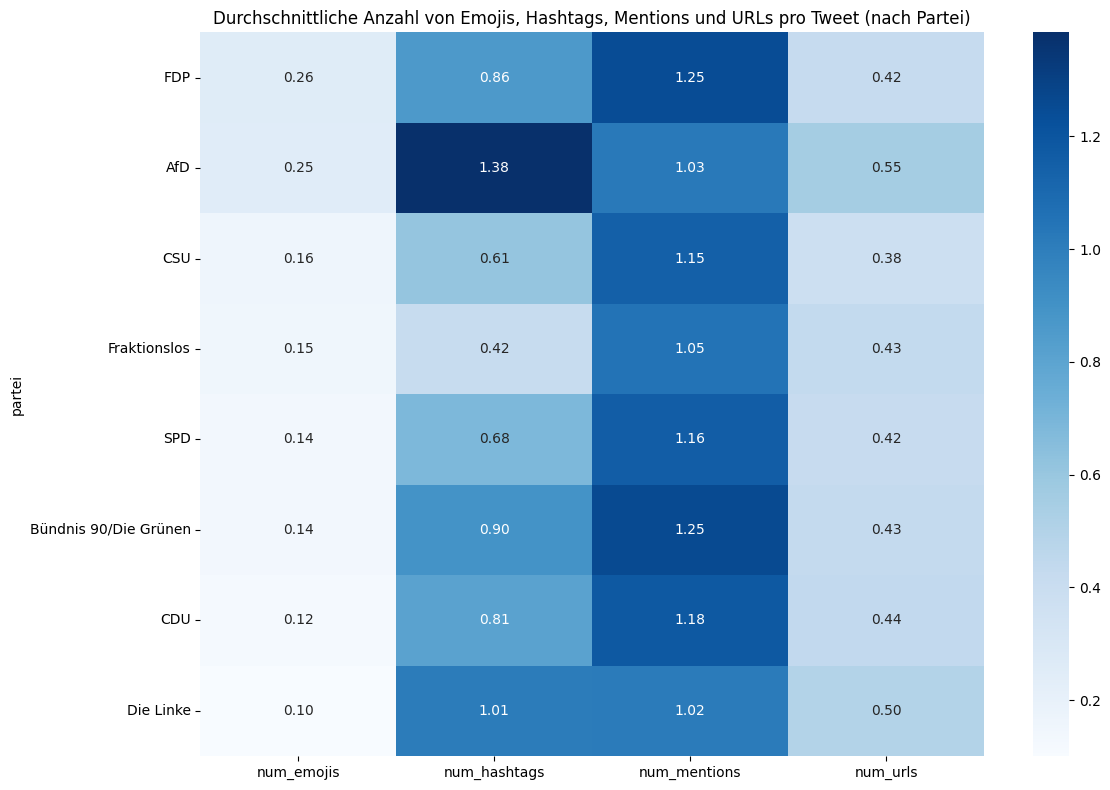

In [64]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(summary, annot=True, fmt=".2f", cmap="Blues")
plt.title("Durchschnittliche Anzahl von Emojis, Hashtags, Mentions und URLs pro Tweet (nach Partei)")
plt.tight_layout()
plt.show()

In [65]:
# Example for hashtags:
def get_top_n(pattern, n=10):
    all_matches = df["text"].str.findall(pattern).explode()
    return all_matches.value_counts().head(n)

print("\nTop 10 Hashtags insgesamt:\n", get_top_n(r"#\w+"))
print("\nTop 10 Mentions insgesamt:\n", get_top_n(r"@\w+"))


Top 10 Hashtags insgesamt:
 text
#AfD          921
#Bundestag    578
#SPD          494
#CDU          382
#Berlin       324
#Corona       320
#Merkel       304
#FDP          272
#EU           209
#CSU          201
Name: count, dtype: int64

Top 10 Mentions insgesamt:
 text
@cducsubt           543
@spdde              498
@spdbt              452
@GrueneBundestag    447
@CDU                402
@Die_Gruenen        371
@fdpbt              334
@fdp                318
@c_lindner          306
@Linksfraktion      294
Name: count, dtype: int64


## **4. Preprocessing (mit Varianten)**
Wir untersuchen verschiedene Preprocessing-Strategien. Ziel: Verschiedene Varianten vorbereiten, die wir anschließend in der Modellierung vergleichen können.

In [54]:
import pandas as pd
import re
import emoji

# Variant 1 functions
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", str(text))

def remove_mentions(text):
    return re.sub(r"@\w+", "", str(text))

def clean_hashtags(text, keep_hash=True):
    if keep_hash:
        return str(text)
    return re.sub(r"#(\w+)", r"\1", str(text))

def emoji_to_text(text, demojize=True):
    if demojize:
        return emoji.demojize(str(text), delimiters=(" ", " "))
    return str(text)

def preprocess_variant(
    text,
    lower=True,
    remove_url=False,
    remove_mention=False,
    remove_hash_symbol=False,
    demojize=False
):
    t = str(text)
    if lower:
        t = t.lower()
    if remove_url:
        t = remove_urls(t)
    if remove_mention:
        t = remove_mentions(t)
    t = clean_hashtags(t, keep_hash=not remove_hash_symbol)
    t = emoji_to_text(t, demojize=demojize)
    t = re.sub(r"\s+", " ", t).strip()
    return t


In [55]:
# Variant 2 (special token) functions
def replace_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", " URL ", str(text))

def replace_mentions(text):
    return re.sub(r"@\w+", " USER ", str(text))

def special_hashtags(text):
    # Replace #hashtag with HASHTAG_hashtag
    return re.sub(r"#(\w+)", r"HASHTAG_\1", str(text))

def preprocess_specialtok(text):
    t = str(text).lower()
    t = replace_urls(t)
    t = replace_mentions(t)
    t = special_hashtags(t)
    t = emoji_to_text(t, demojize=True)
    t = re.sub(r"\s+", " ", t).strip()
    return t

In [56]:
if __name__ == "__main__":
    df = pd.read_csv("../tweets_bundestag.csv", encoding="utf-8-sig")
    min_tweet_count = 1000
    df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
    df = df[df["partei"] != "Unbekannt"]
    df = df.sample(n=50000, random_state=42).reset_index(drop=True)

    # Save different preprocessing variants for ablation studies (Variant 1)
    variants = {
        "raw": df["text"],
        "lowercase": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=False, demojize=False, remove_hash_symbol=False)),
        "no_urls": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=True, remove_mention=False, demojize=False, remove_hash_symbol=False)),
        "no_mentions": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=True, demojize=False, remove_hash_symbol=False)),
        "no_urls_mentions": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=True, remove_mention=True, demojize=False, remove_hash_symbol=False)),
        "demojize": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=False, demojize=True, remove_hash_symbol=False)),
        "no_hashsymbol": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=False, remove_mention=False, demojize=False, remove_hash_symbol=True)),
        "no_urls_mentions_demojize": df["text"].apply(lambda x: preprocess_variant(x, lower=True, remove_url=True, remove_mention=True, demojize=True, remove_hash_symbol=False)),
    }

    for variant, series in variants.items():
        out = df[["partei"]].copy()
        out["text"] = series
        out.to_csv(f"tweets_bundestag_{variant}.csv", index=False, encoding="utf-8-sig")
        print(f"Saved variant: {variant} to tweets_bundestag_{variant}.csv")

    print("Example cleaned texts (Variant 1):")
    print(df.head(10)[["text"]])

    # Special token variant (Variant 2)
    df["specialtok_text"] = df["text"].apply(preprocess_specialtok)
    df[["specialtok_text", "partei"]].to_csv("tweets_bundestag_specialtok.csv", index=False, encoding="utf-8-sig")
    print("Example special token cleaned texts:")
    print(df["specialtok_text"].head(10))

Saved variant: raw to tweets_bundestag_raw.csv
Saved variant: lowercase to tweets_bundestag_lowercase.csv
Saved variant: no_urls to tweets_bundestag_no_urls.csv
Saved variant: no_mentions to tweets_bundestag_no_mentions.csv
Saved variant: no_urls_mentions to tweets_bundestag_no_urls_mentions.csv
Saved variant: demojize to tweets_bundestag_demojize.csv
Saved variant: no_hashsymbol to tweets_bundestag_no_hashsymbol.csv
Saved variant: no_urls_mentions_demojize to tweets_bundestag_no_urls_mentions_demojize.csv
Example cleaned texts (Variant 1):
                                                text
0  RT @OleKreins: Aber bitte nicht das Tempelhofe...
1  @tirsales Leider wird oft vergessen, dass Face...
2  RT @SenIAS_Berlin: Arabisch, Farsi, Kurdisch, ...
3  RT @DanielGollasch: Wann wird denn der Hashtag...
4  RT @Dirk_Behrendt: Heute gedachten wir am @t4e...
5  RT @berlinliebich: Wenn doch SPD und Grüne nur...
6  RT @AndrejHunko: Drohnenangriffe: Regierung wi...
7  RT @juhessen: Heute Abend 

## **5. Modellvergleich: Verschiedene Preprocessing-Varianten**

In diesem Schritt evaluieren wir, wie sich verschiedene Text-Bereinigungsvarianten auf die Modellleistung auswirken.  
Wir verwenden als Modell:
- TF-IDF-Vektorisierung
- Logistische Regression

Kennzahlen:
- Accuracy
- F1-Score (macro & weighted)

Verglichen werden u. a.:
- Raw Text
- Ohne URLs
- Ohne Mentions
- Emojis als Text
- Spezielle Tokens wie USER / URL etc.

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

variants = [
    "raw",
    "lowercase",
    "no_urls",
    "no_mentions",
    "no_urls_mentions",
    "demojize",
    "no_hashsymbol",
    "no_urls_mentions_demojize",
    "specialtok"
]

results = []

for variant in variants:
    print(f"\n=== Testing variant: {variant} ===")
    df = pd.read_csv(f"tweets_bundestag_{variant}.csv", encoding="utf-8-sig")
    df = df.dropna(subset=["text" if variant != "specialtok" else "specialtok_text"])
    text_col = "text" if variant != "specialtok" else "specialtok_text"
    min_tweet_count = 1000
    df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
    sample_size = min(50000, len(df))
    df = df.sample(n=sample_size, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col], df["partei"],
        test_size=0.2,
        random_state=42,
        stratify=df["partei"]
    )

    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {acc:.3f}, Macro F1: {macro_f1:.3f}, Weighted F1: {weighted_f1:.3f}")
    results.append({
        "variant": variant,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    })

print("\n=== Summary Table ===")
print(pd.DataFrame(results))


=== Testing variant: raw ===


Accuracy: 0.415, Macro F1: 0.387, Weighted F1: 0.431

=== Testing variant: lowercase ===
Accuracy: 0.415, Macro F1: 0.387, Weighted F1: 0.431

=== Testing variant: no_urls ===
Accuracy: 0.423, Macro F1: 0.389, Weighted F1: 0.437

=== Testing variant: no_mentions ===
Accuracy: 0.295, Macro F1: 0.276, Weighted F1: 0.305

=== Testing variant: no_urls_mentions ===
Accuracy: 0.299, Macro F1: 0.279, Weighted F1: 0.309

=== Testing variant: demojize ===
Accuracy: 0.416, Macro F1: 0.388, Weighted F1: 0.431

=== Testing variant: no_hashsymbol ===
Accuracy: 0.414, Macro F1: 0.386, Weighted F1: 0.430

=== Testing variant: no_urls_mentions_demojize ===
Accuracy: 0.307, Macro F1: 0.286, Weighted F1: 0.317

=== Testing variant: specialtok ===
Accuracy: 0.290, Macro F1: 0.274, Weighted F1: 0.300

=== Summary Table ===
                     variant  accuracy  macro_f1  weighted_f1
0                        raw  0.415500  0.387152     0.430914
1                  lowercase  0.415500  0.387152     0.430914

## **6. TF-IDF Baseline**

In diesem Abschnitt trainieren wir den Baseline Modell und speichern das Modell sowie den TF-IDF-Vektorisierer mit `joblib` für spätere Nutzung.


In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Choose variant here (e.g., 'raw', 'no_urls', etc.)
VARIANT = "no_urls"

df = pd.read_csv(f"tweets_bundestag_{VARIANT}.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

sample_size = min(50000, len(df))
df = df.sample(n=sample_size, random_state=42)

print("Class distribution in data:\n", df["partei"].value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["partei"],
    test_size=0.2,
    random_state=42,
    stratify=df["partei"]
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Logistic Regression with balanced class weights
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)

print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model and vectorizer for reproducibility/Streamlit
import joblib
joblib.dump(clf, f"lr_model_{VARIANT}.joblib")
joblib.dump(vectorizer, f"tfidf_{VARIANT}.joblib")

Class distribution in data:
 partei
Bündnis 90/Die Grünen    12185
SPD                      10424
CDU                       8172
Die Linke                 7071
FDP                       5005
AfD                       3619
CSU                       2185
Fraktionslos              1094
Name: count, dtype: int64
Classification report:
                       precision    recall  f1-score   support

                  AfD      0.483     0.569     0.523       724
Bündnis 90/Die Grünen      0.580     0.391     0.467      2437
                  CDU      0.464     0.390     0.424      1634
                  CSU      0.177     0.384     0.242       437
            Die Linke      0.435     0.482     0.457      1414
                  FDP      0.410     0.444     0.426      1001
         Fraktionslos      0.081     0.279     0.125       219
                  SPD      0.496     0.410     0.449      2085

             accuracy                          0.423      9951
            macro avg      0.391   

['tfidf_no_urls.joblib']

## **7. TF-IDF + Zusatzfeatures (Emojis, Hashtags, Mentions, URLs)**

Wir erweitern unser Modell um Zusatzinformationen pro Tweet:

- Anzahl Emojis
- Anzahl Hashtags
- Anzahl Mentions
- Anzahl URLs

Die Features werden standardisiert und mit dem TF-IDF-Vektor kombiniert.  
Danach folgt erneut ein Training mit logistischer Regression.

In [68]:
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import joblib

def count_emojis(text):
    return sum(char in emoji.EMOJI_DATA for char in str(text))

def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

def count_mentions(text):
    return len(re.findall(r"@\w+", str(text)))

def count_urls(text):
    return len(re.findall(r"http\S+|www\S+|https\S+", str(text)))

# Choose best variant based on previous results
VARIANT = "no_urls"
df = pd.read_csv(f"tweets_bundestag_{VARIANT}.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

# Add extra features
df["num_emojis"] = df["text"].apply(count_emojis)
df["num_hashtags"] = df["text"].apply(count_hashtags)
df["num_mentions"] = df["text"].apply(count_mentions)
df["num_urls"] = df["text"].apply(count_urls)

sample_size = min(50000, len(df))
df = df.sample(n=sample_size, random_state=42)

X_text = df["text"]
X_extra = df[["num_emojis", "num_hashtags", "num_mentions", "num_urls"]].values
y = df["partei"]

X_train_text, X_test_text, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    X_text, X_extra, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

scaler = StandardScaler(with_mean=False)
X_train_extra_scaled = scaler.fit_transform(X_train_extra)
X_test_extra_scaled = scaler.transform(X_test_extra)

X_train_combined = hstack([X_train_vec, X_train_extra_scaled])
X_test_combined = hstack([X_test_vec, X_test_extra_scaled])

clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_combined, y_train)

y_pred = clf.predict(X_test_combined)
print("Classification report (with extra features):")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

joblib.dump(clf, f"lr_model_extra_{VARIANT}.joblib")
joblib.dump(vectorizer, f"tfidf_extra_{VARIANT}.joblib")
joblib.dump(scaler, f"scaler_extra_{VARIANT}.joblib")

# Feature importances for numeric features
coef = clf.coef_
print("Numeric feature importances (per class):")
for i, col in enumerate(["num_emojis", "num_hashtags", "num_mentions", "num_urls"]):
    print(f"{col}: {coef[:, -(i+1)].mean():.4f}")

Classification report (with extra features):
                       precision    recall  f1-score   support

                  AfD      0.495     0.577     0.533       724
Bündnis 90/Die Grünen      0.577     0.386     0.462      2437
                  CDU      0.462     0.382     0.419      1634
                  CSU      0.188     0.410     0.258       437
            Die Linke      0.431     0.480     0.454      1414
                  FDP      0.407     0.460     0.432      1001
         Fraktionslos      0.078     0.274     0.122       219
                  SPD      0.501     0.410     0.451      2085

             accuracy                          0.424      9951
            macro avg      0.393     0.422     0.391      9951
         weighted avg      0.471     0.424     0.437      9951

Confusion matrix:
[[418  30  43  37  62  36  55  43]
 [ 98 940 203 198 346 211 164 277]
 [ 75 136 625 192 137 133 128 208]
 [ 10  46  63 179  34  25  23  57]
 [ 83 134  82  91 679  99 109 137]
 [ 

## **8. Feature Engineering (strukturierte Merkmale)**

In diesem Schritt extrahieren wir zusätzliche Merkmale aus dem Text,
die nicht durch TF-IDF oder BERT abgedeckt sind:

- Länge des Tweets (in Zeichen/Wörtern)
- durchschnittliche Wortlänge
- Verhältnis von Großbuchstaben
- Häufigkeit von !, ?, ..., Emojis, Mentions, Hashtags, URLs
- Politische Begriffe
- Retweet-Erkennung

In [69]:
import pandas as pd
import re
import emoji

# List of important political terms (example, expand as needed)
POLITICAL_TERMS = [
    "klimaschutz", "freiheit", "bürgergeld", "migration", "rente", "gerechtigkeit",
    "steuern", "digitalisierung", "gesundheit", "bildung", "europa", "verteidigung",
    "arbeitsmarkt", "soziales", "integration", "umweltschutz", "innenpolitik"
]

def count_political_terms(text):
    text = str(text).lower()
    return sum(1 for word in POLITICAL_TERMS if word in text)

def uppercase_ratio(text):
    text = str(text)
    if len(text) == 0:
        return 0
    return sum(1 for c in text if c.isupper()) / len(text)

def avg_word_length(text):
    words = re.findall(r"\w+", str(text))
    if not words:
        return 0
    return sum(len(w) for w in words) / len(words)

def multi_punct_count(text):
    return len(re.findall(r"[!?]{2,}", str(text)))

def count_emojis(text):
    return sum(1 for char in str(text) if char in emoji.EMOJI_DATA)

def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

def count_mentions(text):
    return len(re.findall(r"@\w+", str(text)))

def count_urls(text):
    return len(re.findall(r"http\S+|www\S+|https\S+", str(text)))

def count_dots(text):
    return len(re.findall(r"\.\.+", str(text)))

def is_retweet(text):
    return int(str(text).strip().lower().startswith("rt @"))

if __name__ == "__main__":
    # Use the best preprocessing variant as base
    VARIANT = "no_urls"
    df = pd.read_csv(f"tweets_bundestag_{VARIANT}.csv", encoding="utf-8-sig")
    df = df[df["text"].notna() & (df["text"].str.strip() != "")]
    df = df.reset_index(drop=True)

    # Feature extraction
    df["tweet_length_chars"] = df["text"].apply(len)
    df["tweet_length_words"] = df["text"].apply(lambda x: len(str(x).split()))
    df["avg_word_length"] = df["text"].apply(avg_word_length)
    df["uppercase_ratio"] = df["text"].apply(uppercase_ratio)
    df["exclamations"] = df["text"].apply(lambda x: str(x).count("!"))
    df["questions"] = df["text"].apply(lambda x: str(x).count("?"))
    df["multi_punct_count"] = df["text"].apply(multi_punct_count)
    df["political_term_count"] = df["text"].apply(count_political_terms)
    df["num_emojis"] = df["text"].apply(count_emojis)
    df["num_hashtags"] = df["text"].apply(count_hashtags)
    df["num_mentions"] = df["text"].apply(count_mentions)
    df["num_urls"] = df["text"].apply(count_urls)
    df["dots"] = df["text"].apply(count_dots)
    df["is_retweet"] = df["text"].apply(is_retweet)

    # Save engineered features for downstream use
    df.to_csv("tweets_bundestag_features.csv", index=False, encoding="utf-8-sig")
    print("Feature file saved as tweets_bundestag_features.csv")

Feature file saved as tweets_bundestag_features.csv


## **9. Kombiniertes Modell: BERT + strukturierte Features**

In diesem Schritt kombinieren wir zwei Informationsquellen:

- **Textrepräsentation** über vortrainiertes `bert-base-german-cased` (CLS-Embedding)
- **Strukturierte Merkmale** aus dem vorherigen Feature Engineering (z. B. Emojis, Wortlänge, Großschreibung, politische Begriffe etc.)

Ziel ist es, die Vorhersagegenauigkeit durch die Kombination von Kontext (BERT) und Stil/Merkmalen zu verbessern.


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
import warnings

warnings.filterwarnings("ignore")

# 1. Load features extracted in 07
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
df = df.reset_index(drop=True)
sample_size = min(50000, len(df))
df = df.sample(n=sample_size, random_state=42)

# 2. BERT tokenizer and model (German BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()  # Eval mode

def embed_texts(texts, max_len=128, batch_size=32):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            # CLS token embedding (batch_size, hidden_size)
            cls_emb = output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_emb)
    return np.vstack(embeddings)

X_text = df["text"].tolist()
y = df["partei"]

# 3. Numeric features to use
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
X_numeric = df[feature_cols].values

# (Optional) Balanced sampling: Max 1000 per party
sample_per_party = 1000
df_balanced = (
    df.groupby("partei", group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
      .reset_index(drop=True)
)
X_text_bal = df_balanced["text"].tolist()
X_numeric_bal = df_balanced[feature_cols].values
y_bal = df_balanced["partei"]

# Train/test split on balanced data
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text_bal, X_numeric_bal, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

# 4. Compute BERT embeddings (can be cached if slow)
X_text_train_emb = embed_texts(X_text_train)
X_text_test_emb = embed_texts(X_text_test)

# 5. Scale numeric features
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

# 6. Combine BERT and numeric features
X_train_combined = np.hstack([X_text_train_emb, X_num_train_scaled])
X_test_combined = np.hstack([X_text_test_emb, X_num_test_scaled])

# 7. Train Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
clf.fit(X_train_combined, y_train)

y_pred = clf.predict(X_test_combined)
print("\nClassification report (combined features):")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model and scaler for reproducibility/Streamlit
joblib.dump(clf, "lr_model_combined.joblib")
joblib.dump(scaler, "scaler_combined.joblib")


Classification report (combined features):
                       precision    recall  f1-score   support

                  AfD      0.390     0.425     0.407       200
Bündnis 90/Die Grünen      0.191     0.195     0.193       200
                  CDU      0.224     0.180     0.199       200
                  CSU      0.357     0.410     0.381       200
            Die Linke      0.274     0.260     0.267       200
                  FDP      0.284     0.290     0.287       200
         Fraktionslos      0.336     0.355     0.345       200
                  SPD      0.192     0.175     0.183       200

             accuracy                          0.286      1600
            macro avg      0.281     0.286     0.283      1600
         weighted avg      0.281     0.286     0.283      1600


Confusion matrix:
[[85 23 13 18 10 13 23 15]
 [15 39 19 28 31 31 19 18]
 [20 28 36 31 20 21 21 23]
 [14 16 24 82 15 11 15 23]
 [25 27 16 13 52 20 19 28]
 [20 26 17 13 21 58 23 22]
 [18 23 10 18 23

['scaler_combined.joblib']

## 10. **Klassifikation mit TF-IDF, BERT und Feature Engineering (Random Forest)**

In diesem Abschnitt kombinieren wir drei Arten von Features:

- **TF-IDF-Repräsentationen** der Tweets  
- **BERT-Embeddings** aus dem `bert-base-german-cased` Modell  
- **Manuell extrahierte Features** (z. B. Anzahl Emojis, Großbuchstaben, Hashtags etc.)

Das Modell zur Klassifikation ist ein **Random Forest**, der alle kombinierten Features berücksichtigt.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModel

# Load features
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

# For a quick, balanced test, sample up to 1000 tweets per party
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

Number of tweets used: 8000


In [16]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_sample["text"])

In [8]:
# BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()
def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

Calculating BERT embeddings (this may take several minutes)...


In [11]:
# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

In [17]:
# Combine all features
X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=3))

                       precision    recall  f1-score   support

                  AfD      0.373     0.575     0.453       200
Bündnis 90/Die Grünen      0.203     0.180     0.191       200
                  CDU      0.191     0.175     0.183       200
                  CSU      0.300     0.315     0.307       200
            Die Linke      0.193     0.165     0.178       200
                  FDP      0.342     0.255     0.292       200
         Fraktionslos      0.295     0.395     0.338       200
                  SPD      0.201     0.135     0.162       200

             accuracy                          0.274      1600
            macro avg      0.262     0.274     0.263      1600
         weighted avg      0.262     0.274     0.263      1600



## **11. Klassifikation mit TF-IDF, BERT und Feature Engineering (Logistic Regression)**

In diesem letzten Abschnitt kombinieren wir erneut:

- **TF-IDF-Vektoren**
- **BERT-Embeddings**
- **Feature-Engineering (z. B. Emojis, Hashtags, Großschreibung, etc.)**

Diesmal kommt ein **Logistic Regression-Modell** (mit `saga`-Solver) zum Einsatz.


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import AutoTokenizer, AutoModel

# Load features and sample as before...
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)
print(f"Number of tweets used: {len(df_sample)}")

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_sample["text"])

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()
def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)
print("Calculating BERT embeddings...")
X_bert = embed_texts(df_sample["text"].tolist())

feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)


Number of tweets used: 8000
Calculating BERT embeddings...


In [20]:
clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1, solver='saga')
clf.fit(X_train, y_train)
y_pred_logreg = clf.predict(X_test)
print(classification_report(y_test, y_pred_logreg, digits=3))

                       precision    recall  f1-score   support

                  AfD      0.459     0.510     0.483       200
Bündnis 90/Die Grünen      0.256     0.260     0.258       200
                  CDU      0.245     0.225     0.234       200
                  CSU      0.316     0.325     0.320       200
            Die Linke      0.271     0.245     0.257       200
                  FDP      0.366     0.340     0.352       200
         Fraktionslos      0.276     0.305     0.290       200
                  SPD      0.218     0.215     0.217       200

             accuracy                          0.303      1600
            macro avg      0.301     0.303     0.302      1600
         weighted avg      0.301     0.303     0.302      1600



## **12. Klassifikation mit TF-IDF, BERT und Feature Engineering (LinearSVC)**


In [21]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Load features and sample as before...
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

# TF-IDF 
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_sample["text"])

# BERT 
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()

def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

# Combine all features 
X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize and train LinearSVC
svc_clf = LinearSVC(max_iter=10000, random_state=42)
svc_clf.fit(X_train, y_train)

y_pred_svc = svc_clf.predict(X_test)
print(classification_report(y_test, y_pred_svc, digits=3))


Number of tweets used: 8000
Calculating BERT embeddings (this may take several minutes)...
                       precision    recall  f1-score   support

                  AfD      0.481     0.565     0.520       200
Bündnis 90/Die Grünen      0.275     0.275     0.275       200
                  CDU      0.333     0.305     0.319       200
                  CSU      0.373     0.330     0.350       200
            Die Linke      0.281     0.275     0.278       200
                  FDP      0.382     0.365     0.373       200
         Fraktionslos      0.300     0.330     0.314       200
                  SPD      0.253     0.250     0.251       200

             accuracy                          0.337      1600
            macro avg      0.335     0.337     0.335      1600
         weighted avg      0.335     0.337     0.335      1600



## **13. Klassifikation mit TF-IDF, BERT und Feature Engineering (XGBoost)**


In [2]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Load features and sample as before...
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

# Label-Encoding 
label_encoder = LabelEncoder()
df_sample["label"] = label_encoder.fit_transform(df_sample["partei"])

# TF-IDF 
vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(df_sample["text"])

# BERT 
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()

def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

# Combine all features 
X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)
print(classification_report(y_test_labels, y_pred_labels, digits=3))

c:\Users\HEHEHE\anaconda3\envs\hf-fresh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HEHEHE\AppData\Local\Temp\ipykernel_14288\3436900608.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))


Number of tweets used: 8000
Calculating BERT embeddings (this may take several minutes)...
                       precision    recall  f1-score   support

                  AfD      0.491     0.570     0.528       200
Bündnis 90/Die Grünen      0.277     0.270     0.273       200
                  CDU      0.279     0.275     0.277       200
                  CSU      0.379     0.385     0.382       200
            Die Linke      0.322     0.295     0.308       200
                  FDP      0.474     0.410     0.440       200
         Fraktionslos      0.313     0.385     0.345       200
                  SPD      0.228     0.195     0.210       200

             accuracy                          0.348      1600
            macro avg      0.346     0.348     0.345      1600
         weighted avg      0.346     0.348     0.345      1600



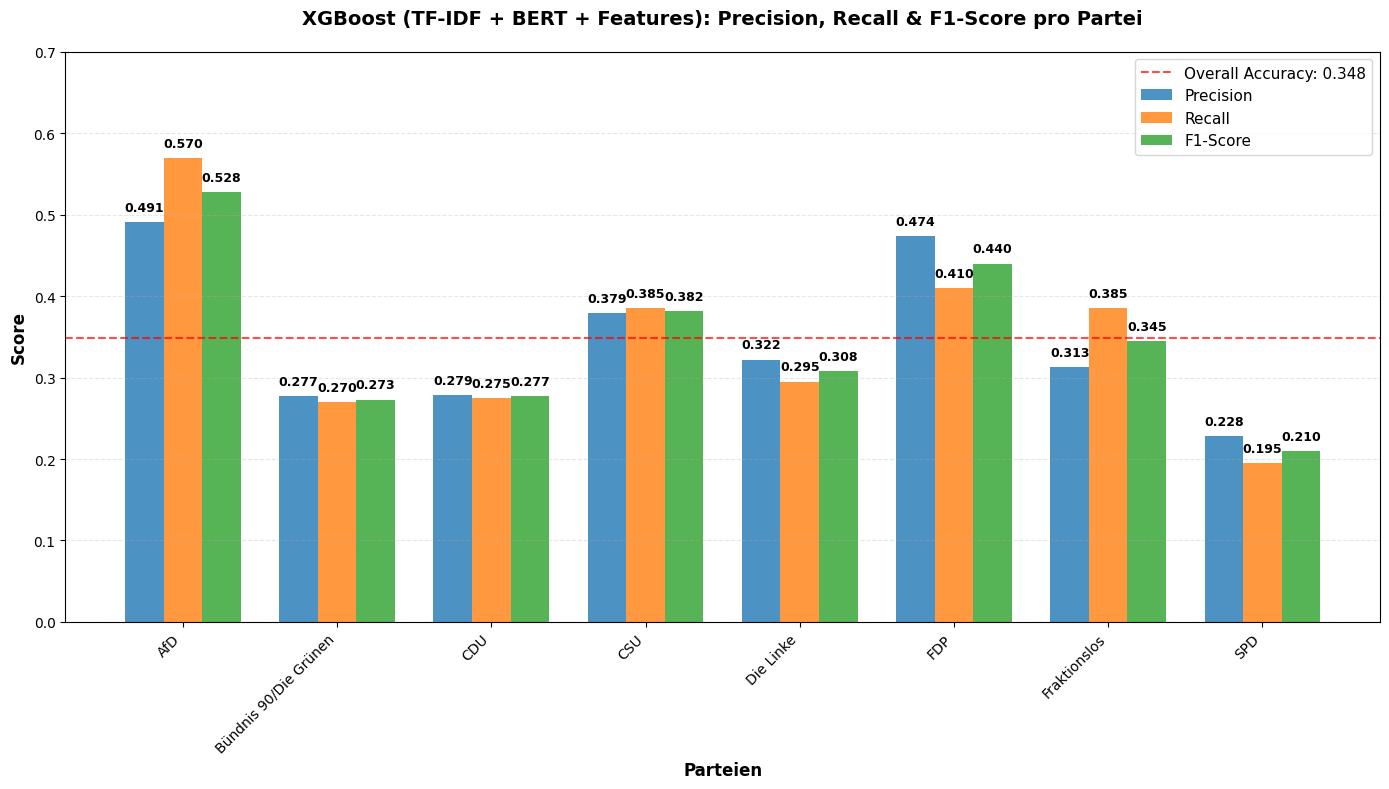

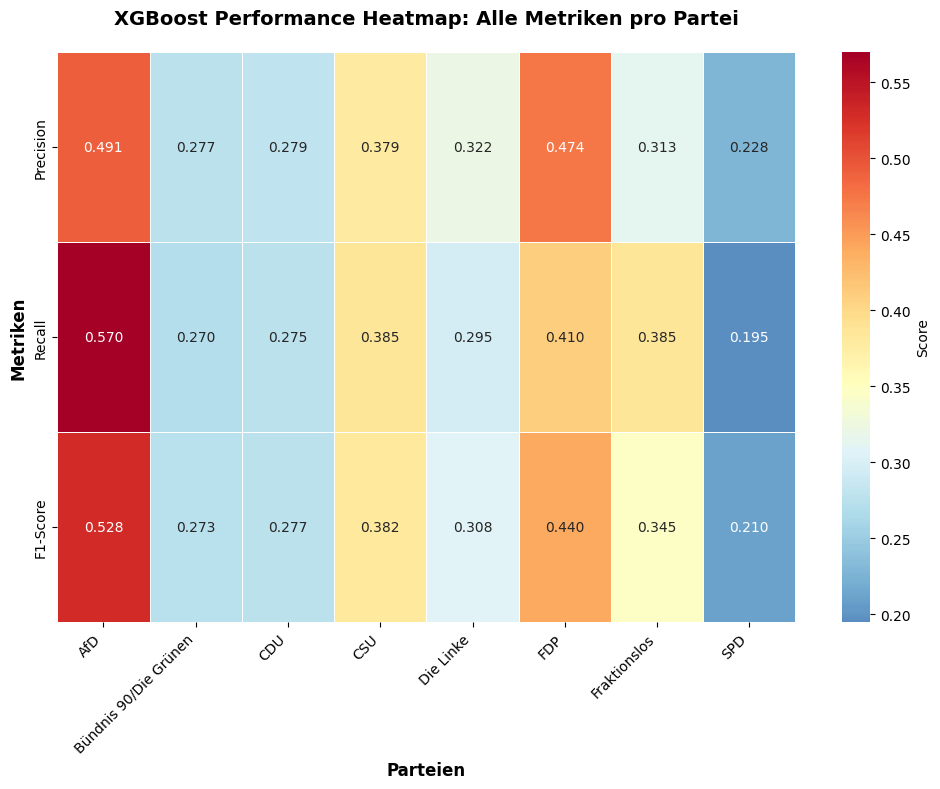

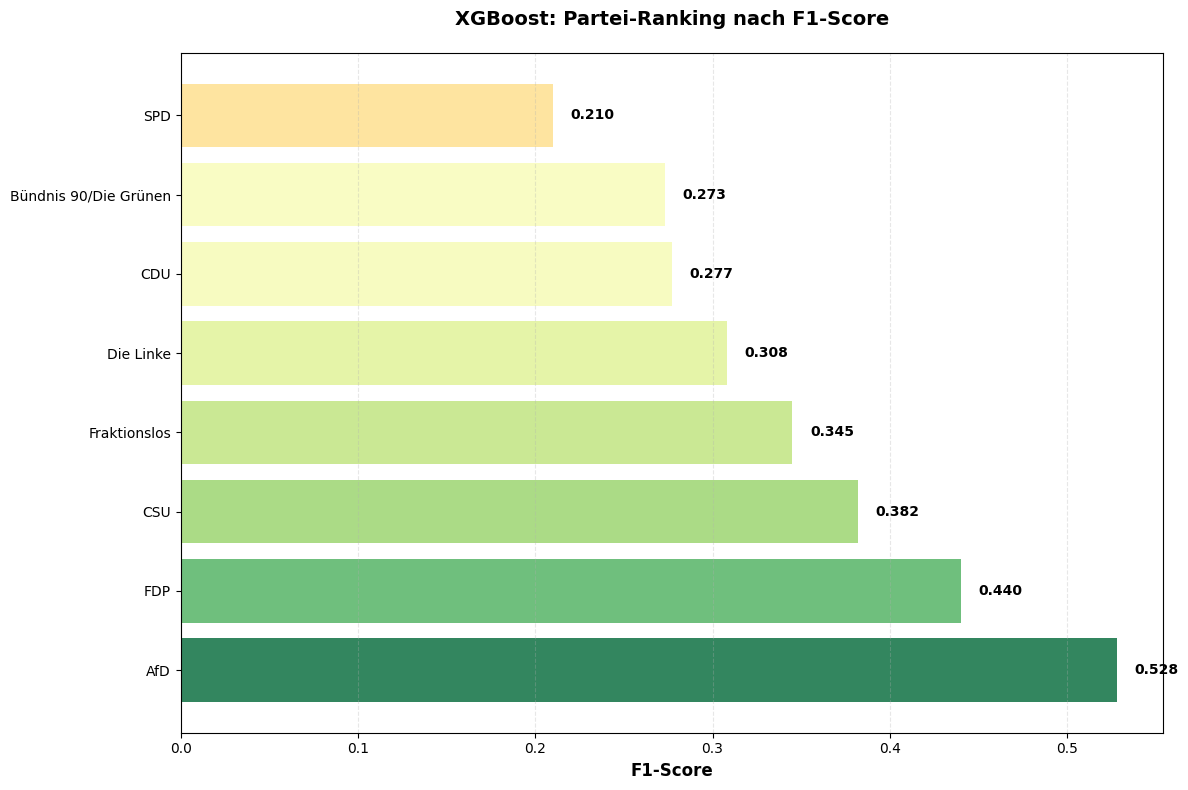

XGBoost (TF-IDF + BERT + Features) - DETAILLIERTE ERGEBNISSE
Partei                    Precision  Recall     F1-Score   Support 
--------------------------------------------------------------------------------
AfD                       0.491      0.570      0.528      200     
Bündnis 90/Die Grünen     0.277      0.270      0.273      200     
CDU                       0.279      0.275      0.277      200     
CSU                       0.379      0.385      0.382      200     
Die Linke                 0.322      0.295      0.308      200     
FDP                       0.474      0.410      0.440      200     
Fraktionslos              0.313      0.385      0.345      200     
SPD                       0.228      0.195      0.210      200     
--------------------------------------------------------------------------------
Overall Accuracy          0.348     
Macro Avg                 0.346      0.348      0.345     
Weighted Avg              0.346      0.348      0.345     

BESTE vs.

<Figure size 1000x800 with 0 Axes>

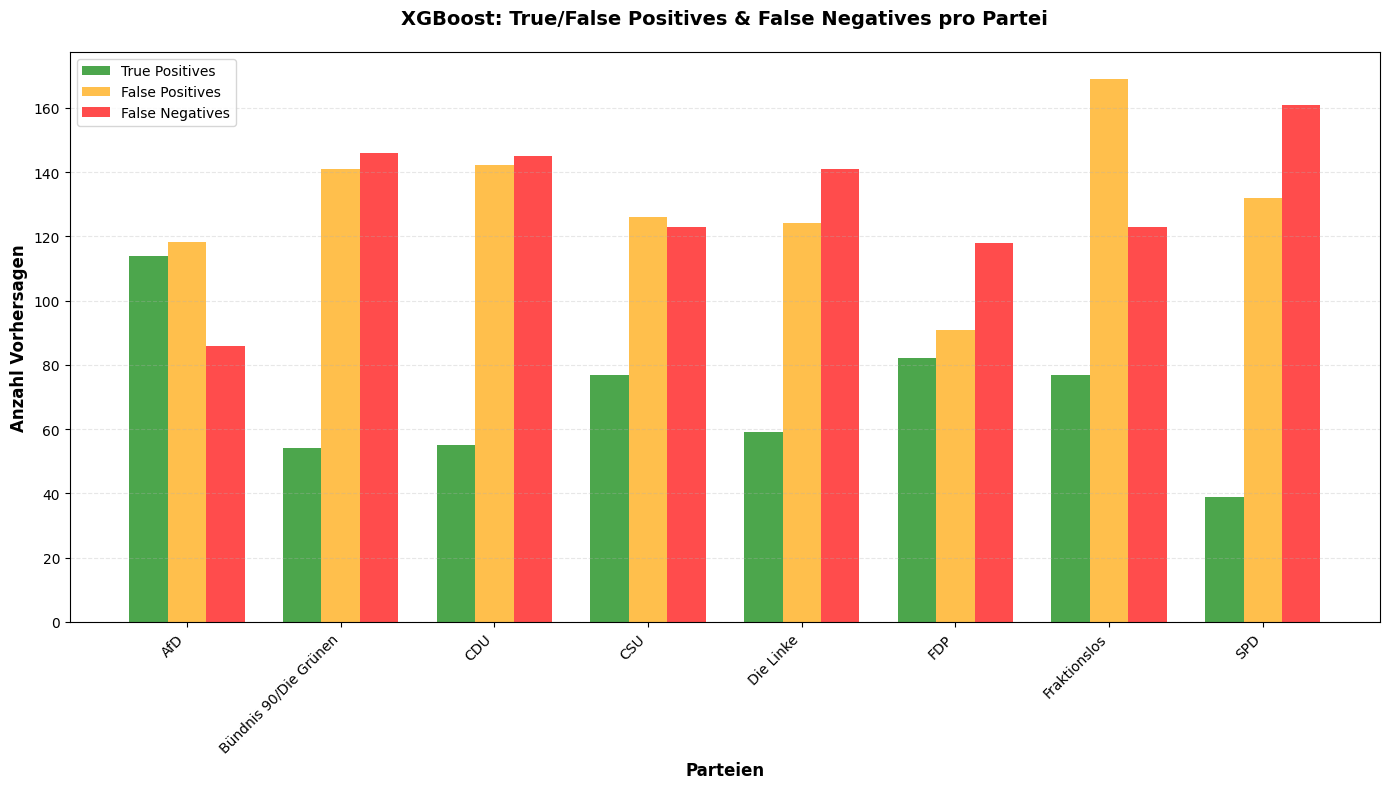

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# XGBoost Ergebnisse aus Teil 13 (TF-IDF + BERT + Features)
parties = ['AfD', 'Bündnis 90/Die Grünen', 'CDU', 'CSU', 'Die Linke', 'FDP', 'Fraktionslos', 'SPD']
precision = [0.491, 0.277, 0.279, 0.379, 0.322, 0.474, 0.313, 0.228]
recall = [0.570, 0.270, 0.275, 0.385, 0.295, 0.410, 0.385, 0.195]
f1_score = [0.528, 0.273, 0.277, 0.382, 0.308, 0.440, 0.345, 0.210]
support = [200] * 8  # Alle Parteien haben 200 Test-Samples

# Gesamtaccuracy
overall_accuracy = 0.348
macro_avg = {'precision': 0.346, 'recall': 0.348, 'f1': 0.345}
weighted_avg = {'precision': 0.346, 'recall': 0.348, 'f1': 0.345}

# 1. Balkendiagramm mit allen Metriken pro Partei
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(parties))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='#2ca02c', alpha=0.8)

# Werte auf den Balken hinzufügen
def add_value_labels(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

add_value_labels(bars1, precision)
add_value_labels(bars2, recall)
add_value_labels(bars3, f1_score)

ax.set_xlabel('Parteien', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('XGBoost (TF-IDF + BERT + Features): Precision, Recall & F1-Score pro Partei', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(parties, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 0.7)

# Gesamtaccuracy als horizontale Linie
ax.axhline(y=overall_accuracy, color='red', linestyle='--', alpha=0.7, 
           label=f'Overall Accuracy: {overall_accuracy:.3f}')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 2. Heatmap für bessere Visualisierung
metrics_data = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
}

df_metrics = pd.DataFrame(metrics_data, index=parties)

plt.figure(figsize=(10, 8))
sns.heatmap(df_metrics.T, annot=True, cmap='RdYlBu_r', center=0.35, 
            fmt='.3f', cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('XGBoost Performance Heatmap: Alle Metriken pro Partei', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Parteien', fontsize=12, fontweight='bold')
plt.ylabel('Metriken', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Ranking der Parteien nach F1-Score
party_performance = list(zip(parties, f1_score))
party_performance_sorted = sorted(party_performance, key=lambda x: x[1], reverse=True)

fig, ax = plt.subplots(figsize=(12, 8))
parties_sorted, f1_sorted = zip(*party_performance_sorted)

colors = plt.cm.RdYlGn([f1/max(f1_score) for f1 in f1_sorted])
bars = ax.barh(range(len(parties_sorted)), f1_sorted, color=colors, alpha=0.8)

# Werte rechts neben den Balken
for i, (party, f1) in enumerate(party_performance_sorted):
    ax.text(f1 + 0.01, i, f'{f1:.3f}', va='center', ha='left', fontweight='bold')

ax.set_yticks(range(len(parties_sorted)))
ax.set_yticklabels(parties_sorted)
ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('XGBoost: Partei-Ranking nach F1-Score', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 4. Zusammenfassung Tabelle
print("=" * 80)
print("XGBoost (TF-IDF + BERT + Features) - DETAILLIERTE ERGEBNISSE")
print("=" * 80)
print(f"{'Partei':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
print("-" * 80)

for i, party in enumerate(parties):
    print(f"{party:<25} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1_score[i]:<10.3f} {support[i]:<8}")

print("-" * 80)
print(f"{'Overall Accuracy':<25} {overall_accuracy:<10.3f}")
print(f"{'Macro Avg':<25} {macro_avg['precision']:<10.3f} {macro_avg['recall']:<10.3f} {macro_avg['f1']:<10.3f}")
print(f"{'Weighted Avg':<25} {weighted_avg['precision']:<10.3f} {weighted_avg['recall']:<10.3f} {weighted_avg['f1']:<10.3f}")

print("\n" + "=" * 80)
print("BESTE vs. SCHLECHTESTE PERFORMANCE:")
print("=" * 80)
print(f"Beste F1-Score:       {party_performance_sorted[0][0]} ({party_performance_sorted[0][1]:.3f})")
print(f"Schlechteste F1-Score: {party_performance_sorted[-1][0]} ({party_performance_sorted[-1][1]:.3f})")
print(f"Differenz:             {party_performance_sorted[0][1] - party_performance_sorted[-1][1]:.3f}")

# 5. Confusion Matrix Simulation (basierend auf den gegebenen Werten)
# Berechnung der Confusion Matrix-Werte basierend auf Precision, Recall und Support
plt.figure(figsize=(10, 8))

# Berechne True Positives, False Positives, False Negatives
tp = [recall[i] * support[i] for i in range(len(parties))]
fp = [tp[i]/precision[i] - tp[i] if precision[i] > 0 else 0 for i in range(len(parties))]
fn = [support[i] - tp[i] for i in range(len(parties))]

# Erstelle ein einfaches Diagramm der TP, FP, FN pro Partei
x = np.arange(len(parties))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width, tp, width, label='True Positives', color='green', alpha=0.7)
bars2 = ax.bar(x, fp, width, label='False Positives', color='orange', alpha=0.7)
bars3 = ax.bar(x + width, fn, width, label='False Negatives', color='red', alpha=0.7)

ax.set_xlabel('Parteien', fontsize=12, fontweight='bold')
ax.set_ylabel('Anzahl Vorhersagen', fontsize=12, fontweight='bold')
ax.set_title('XGBoost: True/False Positives & False Negatives pro Partei', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(parties, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [3]:
import joblib

# Speichern Sie die Modell-Komponenten:
joblib.dump(xgb_clf, "xgb_model_combined.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer_combined.joblib") 
joblib.dump(scaler, "scaler_combined.joblib")
joblib.dump(label_encoder, "label_encoder_combined.joblib")

print("XGBoost-Modell und Komponenten gespeichert!")

XGBoost-Modell und Komponenten gespeichert!


## **14. Klassifikation mit BERT Fine-Tuning**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

# Load features and sample as before...
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

sample_per_party = 1000
df_sample = (
    df.groupby("partei", group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

# Label encoding
label_encoder = LabelEncoder()
df_sample["label"] = label_encoder.fit_transform(df_sample["partei"])
num_labels = len(label_encoder.classes_)

# Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample["text"].tolist(), df_sample["label"].tolist(),
    test_size=0.2, stratify=df_sample["label"], random_state=42
)

# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=num_labels)

# Convert to HuggingFace Dataset
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_ds = Dataset.from_dict({"text": test_texts, "label": test_labels})

# Tokenization
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Fine-tune BERT
trainer.train()

# Evaluate
preds = trainer.predict(test_ds)
y_pred = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred, target_names=label_encoder.classes_))


c:\Users\HEHEHE\anaconda3\envs\hf-fresh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HEHEHE\AppData\Local\Temp\ipykernel_15040\2288613593.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
c:\Users\HEHEHE\anaconda3\envs\hf-fresh\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download

Number of tweets used: 8000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/2400 [00:00<?, ?it/s]c:\Users\HEHEHE\anaconda3\envs\hf-fresh\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 10/2400 [00:29<1:52:09,  2.82s/it]

{'loss': 2.0924, 'grad_norm': 8.350713729858398, 'learning_rate': 1.991666666666667e-05, 'epoch': 0.01}


  1%|          | 20/2400 [00:53<1:30:42,  2.29s/it]

{'loss': 2.0914, 'grad_norm': 7.881750583648682, 'learning_rate': 1.9833333333333335e-05, 'epoch': 0.03}


  1%|▏         | 30/2400 [01:20<1:53:48,  2.88s/it]

{'loss': 2.0913, 'grad_norm': 6.843562602996826, 'learning_rate': 1.9750000000000002e-05, 'epoch': 0.04}


  2%|▏         | 40/2400 [01:45<1:31:27,  2.33s/it]

{'loss': 2.0914, 'grad_norm': 8.255105972290039, 'learning_rate': 1.9666666666666666e-05, 'epoch': 0.05}


  2%|▏         | 50/2400 [02:10<1:38:14,  2.51s/it]

{'loss': 2.0831, 'grad_norm': 12.03885555267334, 'learning_rate': 1.9583333333333333e-05, 'epoch': 0.06}


  2%|▎         | 60/2400 [02:40<1:52:46,  2.89s/it]

{'loss': 2.1062, 'grad_norm': 5.906978607177734, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  3%|▎         | 70/2400 [03:06<1:47:38,  2.77s/it]

{'loss': 2.0535, 'grad_norm': 8.258084297180176, 'learning_rate': 1.9416666666666667e-05, 'epoch': 0.09}


  3%|▎         | 80/2400 [03:30<1:37:15,  2.52s/it]

{'loss': 2.0316, 'grad_norm': 8.843032836914062, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.1}


  4%|▍         | 90/2400 [03:54<1:24:56,  2.21s/it]

{'loss': 1.9255, 'grad_norm': 8.984526634216309, 'learning_rate': 1.925e-05, 'epoch': 0.11}


  4%|▍         | 100/2400 [04:20<1:54:28,  2.99s/it]

{'loss': 1.9894, 'grad_norm': 8.093070030212402, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.12}


  5%|▍         | 110/2400 [04:47<1:44:45,  2.74s/it]

{'loss': 1.9229, 'grad_norm': 9.531656265258789, 'learning_rate': 1.9083333333333338e-05, 'epoch': 0.14}


  5%|▌         | 120/2400 [05:14<1:38:36,  2.60s/it]

{'loss': 2.065, 'grad_norm': 9.476533889770508, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  5%|▌         | 130/2400 [05:42<1:45:04,  2.78s/it]

{'loss': 1.9619, 'grad_norm': 10.495087623596191, 'learning_rate': 1.8916666666666668e-05, 'epoch': 0.16}


  6%|▌         | 140/2400 [06:09<1:35:06,  2.53s/it]

{'loss': 1.9384, 'grad_norm': 10.851954460144043, 'learning_rate': 1.8833333333333335e-05, 'epoch': 0.17}


  6%|▋         | 150/2400 [06:32<1:23:11,  2.22s/it]

{'loss': 2.0271, 'grad_norm': 9.131749153137207, 'learning_rate': 1.8750000000000002e-05, 'epoch': 0.19}


  7%|▋         | 160/2400 [06:57<1:35:40,  2.56s/it]

{'loss': 1.967, 'grad_norm': 8.894372940063477, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.2}


  7%|▋         | 170/2400 [07:22<1:32:29,  2.49s/it]

{'loss': 1.9586, 'grad_norm': 8.505788803100586, 'learning_rate': 1.8583333333333336e-05, 'epoch': 0.21}


  8%|▊         | 180/2400 [07:47<1:31:25,  2.47s/it]

{'loss': 1.9706, 'grad_norm': 10.646028518676758, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


  8%|▊         | 190/2400 [08:12<1:31:19,  2.48s/it]

{'loss': 1.8743, 'grad_norm': 8.514060974121094, 'learning_rate': 1.8416666666666666e-05, 'epoch': 0.24}


  8%|▊         | 200/2400 [08:35<1:21:33,  2.22s/it]

{'loss': 1.989, 'grad_norm': 7.239096641540527, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}


  9%|▉         | 210/2400 [09:01<1:30:54,  2.49s/it]

{'loss': 1.9372, 'grad_norm': 8.52074146270752, 'learning_rate': 1.825e-05, 'epoch': 0.26}


  9%|▉         | 220/2400 [09:26<1:31:16,  2.51s/it]

{'loss': 1.9854, 'grad_norm': 7.193432331085205, 'learning_rate': 1.8166666666666667e-05, 'epoch': 0.28}


 10%|▉         | 230/2400 [09:51<1:24:33,  2.34s/it]

{'loss': 1.9008, 'grad_norm': 11.008445739746094, 'learning_rate': 1.8083333333333334e-05, 'epoch': 0.29}


 10%|█         | 240/2400 [10:16<1:27:33,  2.43s/it]

{'loss': 1.9229, 'grad_norm': 7.651762962341309, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 10%|█         | 250/2400 [10:42<1:31:54,  2.56s/it]

{'loss': 1.8948, 'grad_norm': 8.128543853759766, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}


 11%|█         | 260/2400 [11:07<1:27:40,  2.46s/it]

{'loss': 1.9265, 'grad_norm': 9.415719985961914, 'learning_rate': 1.7833333333333334e-05, 'epoch': 0.33}


 11%|█▏        | 270/2400 [11:33<1:36:18,  2.71s/it]

{'loss': 1.8687, 'grad_norm': 8.459992408752441, 'learning_rate': 1.775e-05, 'epoch': 0.34}


 12%|█▏        | 280/2400 [11:58<1:28:29,  2.50s/it]

{'loss': 2.0015, 'grad_norm': 11.470193862915039, 'learning_rate': 1.7666666666666668e-05, 'epoch': 0.35}


 12%|█▏        | 290/2400 [12:22<1:33:53,  2.67s/it]

{'loss': 1.9023, 'grad_norm': 13.73088264465332, 'learning_rate': 1.7583333333333335e-05, 'epoch': 0.36}


 12%|█▎        | 300/2400 [12:48<1:30:11,  2.58s/it]

{'loss': 1.9583, 'grad_norm': 9.369878768920898, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 13%|█▎        | 310/2400 [13:14<1:28:32,  2.54s/it]

{'loss': 1.7307, 'grad_norm': 8.098487854003906, 'learning_rate': 1.741666666666667e-05, 'epoch': 0.39}


 13%|█▎        | 320/2400 [13:39<1:25:29,  2.47s/it]

{'loss': 1.7925, 'grad_norm': 10.383824348449707, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 14%|█▍        | 330/2400 [14:03<1:25:22,  2.47s/it]

{'loss': 1.8456, 'grad_norm': 11.73619556427002, 'learning_rate': 1.7250000000000003e-05, 'epoch': 0.41}


 14%|█▍        | 340/2400 [14:27<1:23:27,  2.43s/it]

{'loss': 1.9948, 'grad_norm': 10.942867279052734, 'learning_rate': 1.7166666666666666e-05, 'epoch': 0.42}


 15%|█▍        | 350/2400 [14:50<1:18:06,  2.29s/it]

{'loss': 1.7789, 'grad_norm': 10.295965194702148, 'learning_rate': 1.7083333333333333e-05, 'epoch': 0.44}


 15%|█▌        | 360/2400 [15:18<1:33:42,  2.76s/it]

{'loss': 1.8384, 'grad_norm': 12.921257972717285, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 15%|█▌        | 370/2400 [15:44<1:20:51,  2.39s/it]

{'loss': 1.8516, 'grad_norm': 9.37833023071289, 'learning_rate': 1.6916666666666667e-05, 'epoch': 0.46}


 16%|█▌        | 380/2400 [16:12<1:39:53,  2.97s/it]

{'loss': 1.9142, 'grad_norm': 9.37505054473877, 'learning_rate': 1.6833333333333334e-05, 'epoch': 0.47}


 16%|█▋        | 390/2400 [16:38<1:16:48,  2.29s/it]

{'loss': 1.9063, 'grad_norm': 14.349824905395508, 'learning_rate': 1.675e-05, 'epoch': 0.49}


 17%|█▋        | 400/2400 [17:02<1:22:13,  2.47s/it]

{'loss': 1.7944, 'grad_norm': 11.828536987304688, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}


 17%|█▋        | 410/2400 [17:30<1:29:08,  2.69s/it]

{'loss': 1.8544, 'grad_norm': 9.869861602783203, 'learning_rate': 1.6583333333333334e-05, 'epoch': 0.51}


 18%|█▊        | 420/2400 [17:57<1:30:18,  2.74s/it]

{'loss': 1.8942, 'grad_norm': 10.777247428894043, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 18%|█▊        | 430/2400 [18:23<1:24:20,  2.57s/it]

{'loss': 1.8424, 'grad_norm': 11.898816108703613, 'learning_rate': 1.6416666666666668e-05, 'epoch': 0.54}


 18%|█▊        | 440/2400 [18:49<1:28:28,  2.71s/it]

{'loss': 1.8607, 'grad_norm': 9.69448471069336, 'learning_rate': 1.6333333333333335e-05, 'epoch': 0.55}


 19%|█▉        | 450/2400 [19:14<1:15:54,  2.34s/it]

{'loss': 1.8761, 'grad_norm': 10.297186851501465, 'learning_rate': 1.6250000000000002e-05, 'epoch': 0.56}


 19%|█▉        | 460/2400 [19:39<1:22:38,  2.56s/it]

{'loss': 2.0262, 'grad_norm': 9.897808074951172, 'learning_rate': 1.616666666666667e-05, 'epoch': 0.57}


 20%|█▉        | 470/2400 [20:10<2:01:07,  3.77s/it]

{'loss': 1.8635, 'grad_norm': 9.840559005737305, 'learning_rate': 1.6083333333333336e-05, 'epoch': 0.59}


 20%|██        | 480/2400 [20:41<1:45:30,  3.30s/it]

{'loss': 1.8952, 'grad_norm': 8.786773681640625, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 20%|██        | 490/2400 [21:08<1:18:38,  2.47s/it]

{'loss': 1.8402, 'grad_norm': 9.10578727722168, 'learning_rate': 1.5916666666666666e-05, 'epoch': 0.61}


 21%|██        | 500/2400 [21:34<1:28:35,  2.80s/it]

{'loss': 1.8793, 'grad_norm': 12.171138763427734, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


 21%|██▏       | 510/2400 [21:57<1:16:16,  2.42s/it]

{'loss': 1.7541, 'grad_norm': 9.735100746154785, 'learning_rate': 1.575e-05, 'epoch': 0.64}


 22%|██▏       | 520/2400 [22:22<1:15:09,  2.40s/it]

{'loss': 1.9301, 'grad_norm': 8.795551300048828, 'learning_rate': 1.5666666666666667e-05, 'epoch': 0.65}


 22%|██▏       | 530/2400 [22:46<1:16:11,  2.44s/it]

{'loss': 1.8512, 'grad_norm': 8.842655181884766, 'learning_rate': 1.5583333333333334e-05, 'epoch': 0.66}


 22%|██▎       | 540/2400 [23:12<1:16:55,  2.48s/it]

{'loss': 1.9146, 'grad_norm': 11.722885131835938, 'learning_rate': 1.55e-05, 'epoch': 0.68}


 23%|██▎       | 550/2400 [23:36<1:15:04,  2.43s/it]

{'loss': 1.8895, 'grad_norm': 10.276792526245117, 'learning_rate': 1.5416666666666668e-05, 'epoch': 0.69}


 23%|██▎       | 560/2400 [24:00<1:11:43,  2.34s/it]

{'loss': 1.906, 'grad_norm': 12.088305473327637, 'learning_rate': 1.5333333333333334e-05, 'epoch': 0.7}


 24%|██▍       | 570/2400 [24:23<1:05:49,  2.16s/it]

{'loss': 1.8804, 'grad_norm': 10.379556655883789, 'learning_rate': 1.525e-05, 'epoch': 0.71}


 24%|██▍       | 580/2400 [24:49<1:19:38,  2.63s/it]

{'loss': 1.8609, 'grad_norm': 8.468949317932129, 'learning_rate': 1.5166666666666667e-05, 'epoch': 0.72}


 25%|██▍       | 590/2400 [25:15<1:14:37,  2.47s/it]

{'loss': 1.7178, 'grad_norm': 9.1732759475708, 'learning_rate': 1.5083333333333333e-05, 'epoch': 0.74}


 25%|██▌       | 600/2400 [25:41<1:17:38,  2.59s/it]

{'loss': 1.8008, 'grad_norm': 20.721378326416016, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 25%|██▌       | 610/2400 [26:06<1:11:04,  2.38s/it]

{'loss': 1.772, 'grad_norm': 12.82089900970459, 'learning_rate': 1.4916666666666669e-05, 'epoch': 0.76}


 26%|██▌       | 620/2400 [26:31<1:15:38,  2.55s/it]

{'loss': 1.8797, 'grad_norm': 12.419257164001465, 'learning_rate': 1.4833333333333336e-05, 'epoch': 0.78}


 26%|██▋       | 630/2400 [26:56<1:11:53,  2.44s/it]

{'loss': 1.9149, 'grad_norm': 14.120026588439941, 'learning_rate': 1.4750000000000003e-05, 'epoch': 0.79}


 27%|██▋       | 640/2400 [27:23<1:16:36,  2.61s/it]

{'loss': 1.7244, 'grad_norm': 10.985640525817871, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}


 27%|██▋       | 650/2400 [27:48<1:12:02,  2.47s/it]

{'loss': 1.8367, 'grad_norm': 10.001824378967285, 'learning_rate': 1.4583333333333333e-05, 'epoch': 0.81}


 28%|██▊       | 660/2400 [28:15<1:20:12,  2.77s/it]

{'loss': 1.8795, 'grad_norm': 10.567731857299805, 'learning_rate': 1.45e-05, 'epoch': 0.82}


 28%|██▊       | 670/2400 [28:40<1:12:08,  2.50s/it]

{'loss': 1.9033, 'grad_norm': 9.927452087402344, 'learning_rate': 1.4416666666666667e-05, 'epoch': 0.84}


 28%|██▊       | 680/2400 [29:09<1:44:24,  3.64s/it]

{'loss': 1.7699, 'grad_norm': 10.653829574584961, 'learning_rate': 1.4333333333333334e-05, 'epoch': 0.85}


 29%|██▉       | 690/2400 [29:34<1:10:26,  2.47s/it]

{'loss': 1.765, 'grad_norm': 9.977685928344727, 'learning_rate': 1.425e-05, 'epoch': 0.86}


 29%|██▉       | 700/2400 [29:58<1:10:26,  2.49s/it]

{'loss': 1.8079, 'grad_norm': 10.250344276428223, 'learning_rate': 1.416666666666667e-05, 'epoch': 0.88}


 30%|██▉       | 710/2400 [30:23<1:06:35,  2.36s/it]

{'loss': 1.8533, 'grad_norm': 10.262310981750488, 'learning_rate': 1.4083333333333336e-05, 'epoch': 0.89}


 30%|███       | 720/2400 [30:47<1:06:32,  2.38s/it]

{'loss': 1.8125, 'grad_norm': 11.422394752502441, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 30%|███       | 730/2400 [31:11<1:08:00,  2.44s/it]

{'loss': 1.7338, 'grad_norm': 10.26927375793457, 'learning_rate': 1.3916666666666667e-05, 'epoch': 0.91}


 31%|███       | 740/2400 [31:34<58:30,  2.11s/it]  

{'loss': 1.7128, 'grad_norm': 10.187807083129883, 'learning_rate': 1.3833333333333334e-05, 'epoch': 0.93}


 31%|███▏      | 750/2400 [32:00<1:07:55,  2.47s/it]

{'loss': 1.8116, 'grad_norm': 10.47148609161377, 'learning_rate': 1.375e-05, 'epoch': 0.94}


 32%|███▏      | 760/2400 [32:24<1:05:31,  2.40s/it]

{'loss': 1.8646, 'grad_norm': 12.134384155273438, 'learning_rate': 1.3666666666666667e-05, 'epoch': 0.95}


 32%|███▏      | 770/2400 [32:48<1:04:40,  2.38s/it]

{'loss': 1.7886, 'grad_norm': 10.6884183883667, 'learning_rate': 1.3583333333333334e-05, 'epoch': 0.96}


 32%|███▎      | 780/2400 [33:13<1:08:04,  2.52s/it]

{'loss': 1.7649, 'grad_norm': 11.45004653930664, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.97}


 33%|███▎      | 790/2400 [33:36<1:07:39,  2.52s/it]

{'loss': 1.7555, 'grad_norm': 10.690589904785156, 'learning_rate': 1.3416666666666666e-05, 'epoch': 0.99}


 33%|███▎      | 800/2400 [34:01<1:02:58,  2.36s/it]

{'loss': 1.8264, 'grad_norm': 11.518694877624512, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                    
 33%|███▎      | 800/2400 [35:42<1:02:58,  2.36s/it]

{'eval_loss': 1.7576913833618164, 'eval_runtime': 100.1813, 'eval_samples_per_second': 15.971, 'eval_steps_per_second': 1.996, 'epoch': 1.0}


 34%|███▍      | 810/2400 [36:07<1:38:23,  3.71s/it] 

{'loss': 1.6201, 'grad_norm': 13.11844539642334, 'learning_rate': 1.325e-05, 'epoch': 1.01}


 34%|███▍      | 820/2400 [36:31<1:04:56,  2.47s/it]

{'loss': 1.6518, 'grad_norm': 13.063304901123047, 'learning_rate': 1.3166666666666667e-05, 'epoch': 1.02}


 35%|███▍      | 830/2400 [36:57<1:10:53,  2.71s/it]

{'loss': 1.7198, 'grad_norm': 11.816039085388184, 'learning_rate': 1.3083333333333334e-05, 'epoch': 1.04}


 35%|███▌      | 840/2400 [37:24<1:12:13,  2.78s/it]

{'loss': 1.5583, 'grad_norm': 9.835536003112793, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 35%|███▌      | 850/2400 [37:48<1:00:12,  2.33s/it]

{'loss': 1.693, 'grad_norm': 12.552860260009766, 'learning_rate': 1.2916666666666668e-05, 'epoch': 1.06}


 36%|███▌      | 860/2400 [38:14<1:03:33,  2.48s/it]

{'loss': 1.7137, 'grad_norm': 17.303852081298828, 'learning_rate': 1.2833333333333335e-05, 'epoch': 1.07}


 36%|███▋      | 870/2400 [38:42<1:09:04,  2.71s/it]

{'loss': 1.7075, 'grad_norm': 12.022406578063965, 'learning_rate': 1.275e-05, 'epoch': 1.09}


 37%|███▋      | 880/2400 [39:06<57:36,  2.27s/it]  

{'loss': 1.6343, 'grad_norm': 15.001123428344727, 'learning_rate': 1.2666666666666667e-05, 'epoch': 1.1}


 37%|███▋      | 890/2400 [39:31<1:02:39,  2.49s/it]

{'loss': 1.7173, 'grad_norm': 12.098132133483887, 'learning_rate': 1.2583333333333334e-05, 'epoch': 1.11}


 38%|███▊      | 900/2400 [39:58<1:02:01,  2.48s/it]

{'loss': 1.6548, 'grad_norm': 13.222574234008789, 'learning_rate': 1.25e-05, 'epoch': 1.12}


 38%|███▊      | 910/2400 [40:23<1:01:58,  2.50s/it]

{'loss': 1.3683, 'grad_norm': 10.722518920898438, 'learning_rate': 1.2416666666666667e-05, 'epoch': 1.14}


 38%|███▊      | 920/2400 [40:48<1:00:49,  2.47s/it]

{'loss': 1.4885, 'grad_norm': 12.803043365478516, 'learning_rate': 1.2333333333333334e-05, 'epoch': 1.15}


 39%|███▉      | 930/2400 [41:14<1:07:02,  2.74s/it]

{'loss': 1.6942, 'grad_norm': 11.307826042175293, 'learning_rate': 1.2250000000000001e-05, 'epoch': 1.16}


 39%|███▉      | 940/2400 [41:37<55:11,  2.27s/it]  

{'loss': 1.6242, 'grad_norm': 15.09947681427002, 'learning_rate': 1.2166666666666667e-05, 'epoch': 1.18}


 40%|███▉      | 950/2400 [42:01<57:07,  2.36s/it]  

{'loss': 1.6706, 'grad_norm': 13.903898239135742, 'learning_rate': 1.2083333333333333e-05, 'epoch': 1.19}


 40%|████      | 960/2400 [42:26<1:04:01,  2.67s/it]

{'loss': 1.6678, 'grad_norm': 15.672843933105469, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 40%|████      | 970/2400 [42:50<55:26,  2.33s/it]  

{'loss': 1.5856, 'grad_norm': 18.250471115112305, 'learning_rate': 1.1916666666666667e-05, 'epoch': 1.21}


 41%|████      | 980/2400 [43:18<1:01:58,  2.62s/it]

{'loss': 1.5595, 'grad_norm': 12.843202590942383, 'learning_rate': 1.1833333333333334e-05, 'epoch': 1.23}


 41%|████▏     | 990/2400 [43:47<1:14:06,  3.15s/it]

{'loss': 1.8077, 'grad_norm': 12.991405487060547, 'learning_rate': 1.1750000000000001e-05, 'epoch': 1.24}


 42%|████▏     | 1000/2400 [44:12<57:46,  2.48s/it] 

{'loss': 1.4829, 'grad_norm': 13.41298770904541, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


 42%|████▏     | 1010/2400 [44:37<56:18,  2.43s/it]  

{'loss': 1.5331, 'grad_norm': 11.846578598022461, 'learning_rate': 1.1583333333333335e-05, 'epoch': 1.26}


 42%|████▎     | 1020/2400 [45:02<1:00:40,  2.64s/it]

{'loss': 1.524, 'grad_norm': 10.688423156738281, 'learning_rate': 1.15e-05, 'epoch': 1.27}


 43%|████▎     | 1030/2400 [45:25<54:28,  2.39s/it]  

{'loss': 1.5897, 'grad_norm': 14.454080581665039, 'learning_rate': 1.1416666666666667e-05, 'epoch': 1.29}


 43%|████▎     | 1040/2400 [45:50<58:07,  2.56s/it]

{'loss': 1.5323, 'grad_norm': 12.993416786193848, 'learning_rate': 1.1333333333333334e-05, 'epoch': 1.3}


 44%|████▍     | 1050/2400 [46:15<56:36,  2.52s/it]  

{'loss': 1.6085, 'grad_norm': 13.569378852844238, 'learning_rate': 1.125e-05, 'epoch': 1.31}


 44%|████▍     | 1060/2400 [46:43<1:04:39,  2.89s/it]

{'loss': 1.533, 'grad_norm': 11.865676879882812, 'learning_rate': 1.1166666666666668e-05, 'epoch': 1.32}


 45%|████▍     | 1070/2400 [47:07<46:25,  2.09s/it]  

{'loss': 1.5333, 'grad_norm': 17.224218368530273, 'learning_rate': 1.1083333333333335e-05, 'epoch': 1.34}


 45%|████▌     | 1080/2400 [47:34<58:29,  2.66s/it]  

{'loss': 1.6185, 'grad_norm': 13.628844261169434, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 45%|████▌     | 1090/2400 [47:57<51:25,  2.36s/it]

{'loss': 1.5349, 'grad_norm': 16.01432991027832, 'learning_rate': 1.0916666666666667e-05, 'epoch': 1.36}


 46%|████▌     | 1100/2400 [48:23<58:45,  2.71s/it]

{'loss': 1.5697, 'grad_norm': 14.66815185546875, 'learning_rate': 1.0833333333333334e-05, 'epoch': 1.38}


 46%|████▋     | 1110/2400 [48:49<53:45,  2.50s/it]  

{'loss': 1.5821, 'grad_norm': 18.68622398376465, 'learning_rate': 1.075e-05, 'epoch': 1.39}


 47%|████▋     | 1120/2400 [49:13<49:48,  2.33s/it]

{'loss': 1.4654, 'grad_norm': 16.093931198120117, 'learning_rate': 1.0666666666666667e-05, 'epoch': 1.4}


 47%|████▋     | 1130/2400 [49:39<53:33,  2.53s/it]

{'loss': 1.5465, 'grad_norm': 13.624674797058105, 'learning_rate': 1.0583333333333334e-05, 'epoch': 1.41}


 48%|████▊     | 1140/2400 [50:06<53:53,  2.57s/it]  

{'loss': 1.4072, 'grad_norm': 17.218704223632812, 'learning_rate': 1.0500000000000001e-05, 'epoch': 1.43}


 48%|████▊     | 1150/2400 [50:30<51:17,  2.46s/it]

{'loss': 1.4203, 'grad_norm': 13.491786003112793, 'learning_rate': 1.0416666666666668e-05, 'epoch': 1.44}


 48%|████▊     | 1160/2400 [50:56<50:06,  2.42s/it]

{'loss': 1.6057, 'grad_norm': 21.41084861755371, 'learning_rate': 1.0333333333333335e-05, 'epoch': 1.45}


 49%|████▉     | 1170/2400 [51:21<50:30,  2.46s/it]

{'loss': 1.4506, 'grad_norm': 17.1430721282959, 'learning_rate': 1.025e-05, 'epoch': 1.46}


 49%|████▉     | 1180/2400 [51:46<50:48,  2.50s/it]

{'loss': 1.4426, 'grad_norm': 11.279911041259766, 'learning_rate': 1.0166666666666667e-05, 'epoch': 1.48}


 50%|████▉     | 1190/2400 [52:16<53:36,  2.66s/it]  

{'loss': 1.5978, 'grad_norm': 16.863122940063477, 'learning_rate': 1.0083333333333334e-05, 'epoch': 1.49}


 50%|█████     | 1200/2400 [52:40<48:02,  2.40s/it]

{'loss': 1.6821, 'grad_norm': 19.471935272216797, 'learning_rate': 1e-05, 'epoch': 1.5}


 50%|█████     | 1210/2400 [53:08<52:48,  2.66s/it]

{'loss': 1.5192, 'grad_norm': 18.33249282836914, 'learning_rate': 9.916666666666668e-06, 'epoch': 1.51}


 51%|█████     | 1220/2400 [53:32<49:20,  2.51s/it]

{'loss': 1.5329, 'grad_norm': 17.481847763061523, 'learning_rate': 9.833333333333333e-06, 'epoch': 1.52}


 51%|█████▏    | 1230/2400 [53:57<49:26,  2.54s/it]

{'loss': 1.518, 'grad_norm': 18.005775451660156, 'learning_rate': 9.75e-06, 'epoch': 1.54}


 52%|█████▏    | 1240/2400 [54:23<47:38,  2.46s/it]

{'loss': 1.4665, 'grad_norm': 13.847536087036133, 'learning_rate': 9.666666666666667e-06, 'epoch': 1.55}


 52%|█████▏    | 1250/2400 [54:46<41:49,  2.18s/it]

{'loss': 1.5984, 'grad_norm': 17.275070190429688, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}


 52%|█████▎    | 1260/2400 [55:12<50:07,  2.64s/it]

{'loss': 1.3546, 'grad_norm': 21.26565170288086, 'learning_rate': 9.5e-06, 'epoch': 1.57}


 53%|█████▎    | 1270/2400 [55:38<49:30,  2.63s/it]

{'loss': 1.4058, 'grad_norm': 13.772555351257324, 'learning_rate': 9.416666666666667e-06, 'epoch': 1.59}


 53%|█████▎    | 1280/2400 [56:02<42:57,  2.30s/it]

{'loss': 1.5299, 'grad_norm': 14.189899444580078, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 54%|█████▍    | 1290/2400 [56:25<41:28,  2.24s/it]

{'loss': 1.3406, 'grad_norm': 16.214584350585938, 'learning_rate': 9.250000000000001e-06, 'epoch': 1.61}


 54%|█████▍    | 1300/2400 [56:50<45:56,  2.51s/it]

{'loss': 1.4966, 'grad_norm': 18.854604721069336, 'learning_rate': 9.166666666666666e-06, 'epoch': 1.62}


 55%|█████▍    | 1310/2400 [57:15<44:44,  2.46s/it]

{'loss': 1.291, 'grad_norm': 16.039077758789062, 'learning_rate': 9.083333333333333e-06, 'epoch': 1.64}


 55%|█████▌    | 1320/2400 [57:40<43:28,  2.42s/it]

{'loss': 1.435, 'grad_norm': 19.93840217590332, 'learning_rate': 9e-06, 'epoch': 1.65}


 55%|█████▌    | 1330/2400 [58:06<47:40,  2.67s/it]

{'loss': 1.4865, 'grad_norm': 22.715482711791992, 'learning_rate': 8.916666666666667e-06, 'epoch': 1.66}


 56%|█████▌    | 1340/2400 [58:33<45:12,  2.56s/it]

{'loss': 1.5991, 'grad_norm': 18.223941802978516, 'learning_rate': 8.833333333333334e-06, 'epoch': 1.68}


 56%|█████▋    | 1350/2400 [58:59<50:08,  2.86s/it]

{'loss': 1.5162, 'grad_norm': 15.716521263122559, 'learning_rate': 8.750000000000001e-06, 'epoch': 1.69}


 57%|█████▋    | 1360/2400 [59:26<43:39,  2.52s/it]

{'loss': 1.3985, 'grad_norm': 16.687389373779297, 'learning_rate': 8.666666666666668e-06, 'epoch': 1.7}


 57%|█████▋    | 1370/2400 [59:50<42:46,  2.49s/it]

{'loss': 1.4647, 'grad_norm': 18.019996643066406, 'learning_rate': 8.583333333333333e-06, 'epoch': 1.71}


 57%|█████▊    | 1380/2400 [1:00:13<36:52,  2.17s/it]

{'loss': 1.5152, 'grad_norm': 25.30169677734375, 'learning_rate': 8.5e-06, 'epoch': 1.73}


 58%|█████▊    | 1390/2400 [1:00:42<59:45,  3.55s/it]

{'loss': 1.4299, 'grad_norm': 19.109920501708984, 'learning_rate': 8.416666666666667e-06, 'epoch': 1.74}


 58%|█████▊    | 1400/2400 [1:01:07<43:57,  2.64s/it]

{'loss': 1.4677, 'grad_norm': 20.164499282836914, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.75}


 59%|█████▉    | 1410/2400 [1:01:35<42:44,  2.59s/it]

{'loss': 1.479, 'grad_norm': 15.223575592041016, 'learning_rate': 8.25e-06, 'epoch': 1.76}


 59%|█████▉    | 1420/2400 [1:02:02<45:30,  2.79s/it]

{'loss': 1.4665, 'grad_norm': 15.914782524108887, 'learning_rate': 8.166666666666668e-06, 'epoch': 1.77}


 60%|█████▉    | 1430/2400 [1:02:30<46:51,  2.90s/it]

{'loss': 1.3865, 'grad_norm': 14.608563423156738, 'learning_rate': 8.083333333333334e-06, 'epoch': 1.79}


 60%|██████    | 1440/2400 [1:02:59<47:19,  2.96s/it]

{'loss': 1.5859, 'grad_norm': 23.744998931884766, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 60%|██████    | 1450/2400 [1:03:27<45:23,  2.87s/it]

{'loss': 1.5031, 'grad_norm': 17.998807907104492, 'learning_rate': 7.916666666666667e-06, 'epoch': 1.81}


 61%|██████    | 1460/2400 [1:03:51<40:44,  2.60s/it]

{'loss': 1.3169, 'grad_norm': 18.299884796142578, 'learning_rate': 7.833333333333333e-06, 'epoch': 1.82}


 61%|██████▏   | 1470/2400 [1:04:17<40:39,  2.62s/it]

{'loss': 1.4038, 'grad_norm': 22.949243545532227, 'learning_rate': 7.75e-06, 'epoch': 1.84}


 62%|██████▏   | 1480/2400 [1:04:42<40:52,  2.67s/it]

{'loss': 1.4138, 'grad_norm': 14.328954696655273, 'learning_rate': 7.666666666666667e-06, 'epoch': 1.85}


 62%|██████▏   | 1490/2400 [1:05:09<38:48,  2.56s/it]

{'loss': 1.3707, 'grad_norm': 13.638834953308105, 'learning_rate': 7.583333333333333e-06, 'epoch': 1.86}


 62%|██████▎   | 1500/2400 [1:05:34<37:29,  2.50s/it]

{'loss': 1.4681, 'grad_norm': 18.640592575073242, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 63%|██████▎   | 1510/2400 [1:06:00<39:34,  2.67s/it]

{'loss': 1.3859, 'grad_norm': 24.20545768737793, 'learning_rate': 7.416666666666668e-06, 'epoch': 1.89}


 63%|██████▎   | 1520/2400 [1:06:26<39:58,  2.73s/it]

{'loss': 1.2905, 'grad_norm': 13.466401100158691, 'learning_rate': 7.333333333333333e-06, 'epoch': 1.9}


 64%|██████▍   | 1530/2400 [1:06:51<33:56,  2.34s/it]

{'loss': 1.4315, 'grad_norm': 15.72610855102539, 'learning_rate': 7.25e-06, 'epoch': 1.91}


 64%|██████▍   | 1540/2400 [1:07:19<35:42,  2.49s/it]

{'loss': 1.4873, 'grad_norm': 25.24359893798828, 'learning_rate': 7.166666666666667e-06, 'epoch': 1.93}


 65%|██████▍   | 1550/2400 [1:07:43<31:33,  2.23s/it]

{'loss': 1.3464, 'grad_norm': 16.787086486816406, 'learning_rate': 7.083333333333335e-06, 'epoch': 1.94}


 65%|██████▌   | 1560/2400 [1:08:09<37:28,  2.68s/it]

{'loss': 1.4036, 'grad_norm': 17.868318557739258, 'learning_rate': 7e-06, 'epoch': 1.95}


 65%|██████▌   | 1570/2400 [1:08:34<34:41,  2.51s/it]

{'loss': 1.3615, 'grad_norm': 11.634182929992676, 'learning_rate': 6.916666666666667e-06, 'epoch': 1.96}


 66%|██████▌   | 1580/2400 [1:09:01<36:04,  2.64s/it]

{'loss': 1.5456, 'grad_norm': 19.088659286499023, 'learning_rate': 6.833333333333334e-06, 'epoch': 1.98}


 66%|██████▋   | 1590/2400 [1:09:26<32:06,  2.38s/it]

{'loss': 1.3679, 'grad_norm': 19.265260696411133, 'learning_rate': 6.750000000000001e-06, 'epoch': 1.99}


 67%|██████▋   | 1600/2400 [1:09:55<40:35,  3.04s/it]

{'loss': 1.5227, 'grad_norm': 22.284116744995117, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                     
 67%|██████▋   | 1600/2400 [1:11:35<40:35,  3.04s/it]

{'eval_loss': 1.688917875289917, 'eval_runtime': 99.8908, 'eval_samples_per_second': 16.017, 'eval_steps_per_second': 2.002, 'epoch': 2.0}


 67%|██████▋   | 1610/2400 [1:11:58<45:49,  3.48s/it]  

{'loss': 1.1065, 'grad_norm': 19.300519943237305, 'learning_rate': 6.5833333333333335e-06, 'epoch': 2.01}


 68%|██████▊   | 1620/2400 [1:12:28<37:46,  2.91s/it]

{'loss': 1.298, 'grad_norm': 19.776599884033203, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.02}


 68%|██████▊   | 1630/2400 [1:12:55<33:05,  2.58s/it]

{'loss': 1.2363, 'grad_norm': 16.370433807373047, 'learning_rate': 6.416666666666667e-06, 'epoch': 2.04}


 68%|██████▊   | 1640/2400 [1:13:19<29:39,  2.34s/it]

{'loss': 1.3463, 'grad_norm': 21.05567741394043, 'learning_rate': 6.333333333333333e-06, 'epoch': 2.05}


 69%|██████▉   | 1650/2400 [1:13:45<32:59,  2.64s/it]

{'loss': 1.0314, 'grad_norm': 15.867915153503418, 'learning_rate': 6.25e-06, 'epoch': 2.06}


 69%|██████▉   | 1660/2400 [1:14:08<28:41,  2.33s/it]

{'loss': 1.2127, 'grad_norm': 16.802305221557617, 'learning_rate': 6.166666666666667e-06, 'epoch': 2.08}


 70%|██████▉   | 1670/2400 [1:14:34<31:04,  2.55s/it]

{'loss': 1.2518, 'grad_norm': 11.283979415893555, 'learning_rate': 6.083333333333333e-06, 'epoch': 2.09}


 70%|███████   | 1680/2400 [1:14:58<27:40,  2.31s/it]

{'loss': 1.1836, 'grad_norm': 25.37207794189453, 'learning_rate': 6e-06, 'epoch': 2.1}


 70%|███████   | 1690/2400 [1:15:24<30:52,  2.61s/it]

{'loss': 1.1318, 'grad_norm': 18.79288673400879, 'learning_rate': 5.916666666666667e-06, 'epoch': 2.11}


 71%|███████   | 1700/2400 [1:15:48<27:39,  2.37s/it]

{'loss': 1.2664, 'grad_norm': 21.09343147277832, 'learning_rate': 5.833333333333334e-06, 'epoch': 2.12}


 71%|███████▏  | 1710/2400 [1:16:12<26:40,  2.32s/it]

{'loss': 1.145, 'grad_norm': 25.710010528564453, 'learning_rate': 5.75e-06, 'epoch': 2.14}


 72%|███████▏  | 1720/2400 [1:16:38<30:09,  2.66s/it]

{'loss': 1.2212, 'grad_norm': 19.250465393066406, 'learning_rate': 5.666666666666667e-06, 'epoch': 2.15}


 72%|███████▏  | 1730/2400 [1:17:03<28:04,  2.51s/it]

{'loss': 1.0865, 'grad_norm': 22.263545989990234, 'learning_rate': 5.583333333333334e-06, 'epoch': 2.16}


 72%|███████▎  | 1740/2400 [1:17:27<25:01,  2.27s/it]

{'loss': 1.3375, 'grad_norm': 17.82074546813965, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.17}


 73%|███████▎  | 1750/2400 [1:17:52<25:11,  2.33s/it]

{'loss': 1.1203, 'grad_norm': 23.558088302612305, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.19}


 73%|███████▎  | 1760/2400 [1:18:17<27:07,  2.54s/it]

{'loss': 1.1688, 'grad_norm': 14.501508712768555, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.2}


 74%|███████▍  | 1770/2400 [1:18:42<24:54,  2.37s/it]

{'loss': 0.9079, 'grad_norm': 13.240062713623047, 'learning_rate': 5.2500000000000006e-06, 'epoch': 2.21}


 74%|███████▍  | 1780/2400 [1:19:08<25:07,  2.43s/it]

{'loss': 1.2582, 'grad_norm': 19.41443634033203, 'learning_rate': 5.1666666666666675e-06, 'epoch': 2.23}


 75%|███████▍  | 1790/2400 [1:19:36<29:04,  2.86s/it]

{'loss': 1.0318, 'grad_norm': 15.350768089294434, 'learning_rate': 5.0833333333333335e-06, 'epoch': 2.24}


 75%|███████▌  | 1800/2400 [1:20:01<23:23,  2.34s/it]

{'loss': 1.1363, 'grad_norm': 23.16328239440918, 'learning_rate': 5e-06, 'epoch': 2.25}


 75%|███████▌  | 1810/2400 [1:20:29<26:14,  2.67s/it]

{'loss': 1.1654, 'grad_norm': 11.887479782104492, 'learning_rate': 4.9166666666666665e-06, 'epoch': 2.26}


 76%|███████▌  | 1820/2400 [1:20:56<25:09,  2.60s/it]

{'loss': 1.151, 'grad_norm': 17.812931060791016, 'learning_rate': 4.833333333333333e-06, 'epoch': 2.27}


 76%|███████▋  | 1830/2400 [1:21:22<24:59,  2.63s/it]

{'loss': 1.1946, 'grad_norm': 18.28278350830078, 'learning_rate': 4.75e-06, 'epoch': 2.29}


 77%|███████▋  | 1840/2400 [1:21:52<24:30,  2.63s/it]

{'loss': 1.1142, 'grad_norm': 18.172550201416016, 'learning_rate': 4.666666666666667e-06, 'epoch': 2.3}


 77%|███████▋  | 1850/2400 [1:22:17<22:09,  2.42s/it]

{'loss': 1.2866, 'grad_norm': 17.3522891998291, 'learning_rate': 4.583333333333333e-06, 'epoch': 2.31}


 78%|███████▊  | 1860/2400 [1:22:43<22:43,  2.52s/it]

{'loss': 0.9914, 'grad_norm': 21.434293746948242, 'learning_rate': 4.5e-06, 'epoch': 2.33}


 78%|███████▊  | 1870/2400 [1:23:09<22:09,  2.51s/it]

{'loss': 1.1198, 'grad_norm': 12.658257484436035, 'learning_rate': 4.416666666666667e-06, 'epoch': 2.34}


 78%|███████▊  | 1880/2400 [1:23:35<20:57,  2.42s/it]

{'loss': 1.1132, 'grad_norm': 19.30548667907715, 'learning_rate': 4.333333333333334e-06, 'epoch': 2.35}


 79%|███████▉  | 1890/2400 [1:23:59<20:11,  2.37s/it]

{'loss': 1.249, 'grad_norm': 19.017683029174805, 'learning_rate': 4.25e-06, 'epoch': 2.36}


 79%|███████▉  | 1900/2400 [1:24:29<23:05,  2.77s/it]

{'loss': 1.2955, 'grad_norm': 24.615991592407227, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.38}


 80%|███████▉  | 1910/2400 [1:24:53<18:40,  2.29s/it]

{'loss': 1.1103, 'grad_norm': 23.445066452026367, 'learning_rate': 4.083333333333334e-06, 'epoch': 2.39}


 80%|████████  | 1920/2400 [1:25:18<19:51,  2.48s/it]

{'loss': 1.1683, 'grad_norm': 16.897031784057617, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 80%|████████  | 1930/2400 [1:25:42<17:04,  2.18s/it]

{'loss': 1.2083, 'grad_norm': 24.367935180664062, 'learning_rate': 3.916666666666667e-06, 'epoch': 2.41}


 81%|████████  | 1940/2400 [1:26:08<19:58,  2.61s/it]

{'loss': 1.2411, 'grad_norm': 19.6485538482666, 'learning_rate': 3.833333333333334e-06, 'epoch': 2.42}


 81%|████████▏ | 1950/2400 [1:26:33<19:38,  2.62s/it]

{'loss': 1.0714, 'grad_norm': 18.402019500732422, 'learning_rate': 3.7500000000000005e-06, 'epoch': 2.44}


 82%|████████▏ | 1960/2400 [1:26:57<17:46,  2.42s/it]

{'loss': 1.097, 'grad_norm': 18.184011459350586, 'learning_rate': 3.6666666666666666e-06, 'epoch': 2.45}


 82%|████████▏ | 1970/2400 [1:27:21<17:57,  2.51s/it]

{'loss': 1.0786, 'grad_norm': 17.02843475341797, 'learning_rate': 3.5833333333333335e-06, 'epoch': 2.46}


 82%|████████▎ | 1980/2400 [1:27:46<17:58,  2.57s/it]

{'loss': 1.0928, 'grad_norm': 17.399471282958984, 'learning_rate': 3.5e-06, 'epoch': 2.48}


 83%|████████▎ | 1990/2400 [1:28:11<17:54,  2.62s/it]

{'loss': 1.2205, 'grad_norm': 24.805639266967773, 'learning_rate': 3.416666666666667e-06, 'epoch': 2.49}


 83%|████████▎ | 2000/2400 [1:28:35<16:36,  2.49s/it]

{'loss': 1.1426, 'grad_norm': 19.649738311767578, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 84%|████████▍ | 2010/2400 [1:29:02<16:32,  2.55s/it]

{'loss': 1.135, 'grad_norm': 19.869394302368164, 'learning_rate': 3.2500000000000002e-06, 'epoch': 2.51}


 84%|████████▍ | 2020/2400 [1:29:27<16:19,  2.58s/it]

{'loss': 1.0694, 'grad_norm': 26.980609893798828, 'learning_rate': 3.1666666666666667e-06, 'epoch': 2.52}


 85%|████████▍ | 2030/2400 [1:29:53<15:35,  2.53s/it]

{'loss': 1.0875, 'grad_norm': 14.382356643676758, 'learning_rate': 3.0833333333333336e-06, 'epoch': 2.54}


 85%|████████▌ | 2040/2400 [1:30:20<16:12,  2.70s/it]

{'loss': 1.1235, 'grad_norm': 22.709806442260742, 'learning_rate': 3e-06, 'epoch': 2.55}


 85%|████████▌ | 2050/2400 [1:30:43<13:51,  2.37s/it]

{'loss': 1.1112, 'grad_norm': 23.420310974121094, 'learning_rate': 2.916666666666667e-06, 'epoch': 2.56}


 86%|████████▌ | 2060/2400 [1:31:08<13:48,  2.44s/it]

{'loss': 1.2603, 'grad_norm': 21.579143524169922, 'learning_rate': 2.8333333333333335e-06, 'epoch': 2.58}


 86%|████████▋ | 2070/2400 [1:31:32<12:47,  2.33s/it]

{'loss': 1.0234, 'grad_norm': 20.276546478271484, 'learning_rate': 2.7500000000000004e-06, 'epoch': 2.59}


 87%|████████▋ | 2080/2400 [1:31:58<13:03,  2.45s/it]

{'loss': 1.1646, 'grad_norm': 27.041614532470703, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.6}


 87%|████████▋ | 2090/2400 [1:32:22<12:03,  2.33s/it]

{'loss': 1.0454, 'grad_norm': 18.662246704101562, 'learning_rate': 2.5833333333333337e-06, 'epoch': 2.61}


 88%|████████▊ | 2100/2400 [1:32:45<11:31,  2.31s/it]

{'loss': 1.1797, 'grad_norm': 12.498507499694824, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 88%|████████▊ | 2110/2400 [1:33:11<11:45,  2.43s/it]

{'loss': 1.0962, 'grad_norm': 21.680028915405273, 'learning_rate': 2.4166666666666667e-06, 'epoch': 2.64}


 88%|████████▊ | 2120/2400 [1:33:37<11:46,  2.52s/it]

{'loss': 1.0975, 'grad_norm': 16.22684669494629, 'learning_rate': 2.3333333333333336e-06, 'epoch': 2.65}


 89%|████████▉ | 2130/2400 [1:34:02<11:12,  2.49s/it]

{'loss': 1.1073, 'grad_norm': 18.91463851928711, 'learning_rate': 2.25e-06, 'epoch': 2.66}


 89%|████████▉ | 2140/2400 [1:34:27<11:28,  2.65s/it]

{'loss': 1.0869, 'grad_norm': 23.843061447143555, 'learning_rate': 2.166666666666667e-06, 'epoch': 2.67}


 90%|████████▉ | 2150/2400 [1:34:51<09:18,  2.23s/it]

{'loss': 1.1997, 'grad_norm': 26.78914451599121, 'learning_rate': 2.0833333333333334e-06, 'epoch': 2.69}


 90%|█████████ | 2160/2400 [1:35:18<11:12,  2.80s/it]

{'loss': 1.0908, 'grad_norm': 30.965974807739258, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 90%|█████████ | 2170/2400 [1:35:48<10:52,  2.84s/it]

{'loss': 0.938, 'grad_norm': 25.372482299804688, 'learning_rate': 1.916666666666667e-06, 'epoch': 2.71}


 91%|█████████ | 2180/2400 [1:36:17<10:07,  2.76s/it]

{'loss': 1.2147, 'grad_norm': 15.326739311218262, 'learning_rate': 1.8333333333333333e-06, 'epoch': 2.73}


 91%|█████████▏| 2190/2400 [1:36:46<11:52,  3.39s/it]

{'loss': 1.2166, 'grad_norm': 28.824005126953125, 'learning_rate': 1.75e-06, 'epoch': 2.74}


 92%|█████████▏| 2200/2400 [1:37:11<07:54,  2.37s/it]

{'loss': 1.1776, 'grad_norm': 24.04218864440918, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.75}


 92%|█████████▏| 2210/2400 [1:37:38<08:18,  2.63s/it]

{'loss': 0.9342, 'grad_norm': 25.104429244995117, 'learning_rate': 1.5833333333333333e-06, 'epoch': 2.76}


 92%|█████████▎| 2220/2400 [1:38:04<07:57,  2.65s/it]

{'loss': 1.3229, 'grad_norm': 29.62108039855957, 'learning_rate': 1.5e-06, 'epoch': 2.77}


 93%|█████████▎| 2230/2400 [1:38:31<07:19,  2.59s/it]

{'loss': 1.1862, 'grad_norm': 24.775230407714844, 'learning_rate': 1.4166666666666667e-06, 'epoch': 2.79}


 93%|█████████▎| 2240/2400 [1:38:58<07:24,  2.78s/it]

{'loss': 1.2661, 'grad_norm': 19.823972702026367, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}


 94%|█████████▍| 2250/2400 [1:39:23<06:08,  2.45s/it]

{'loss': 1.0108, 'grad_norm': 28.994112014770508, 'learning_rate': 1.25e-06, 'epoch': 2.81}


 94%|█████████▍| 2260/2400 [1:39:52<06:59,  2.99s/it]

{'loss': 1.1182, 'grad_norm': 17.156776428222656, 'learning_rate': 1.1666666666666668e-06, 'epoch': 2.83}


 95%|█████████▍| 2270/2400 [1:40:18<05:24,  2.50s/it]

{'loss': 1.2698, 'grad_norm': 21.893600463867188, 'learning_rate': 1.0833333333333335e-06, 'epoch': 2.84}


 95%|█████████▌| 2280/2400 [1:40:43<05:05,  2.55s/it]

{'loss': 1.0994, 'grad_norm': 17.85591697692871, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 95%|█████████▌| 2290/2400 [1:41:08<04:29,  2.45s/it]

{'loss': 1.1148, 'grad_norm': 22.4663143157959, 'learning_rate': 9.166666666666666e-07, 'epoch': 2.86}


 96%|█████████▌| 2300/2400 [1:41:33<04:03,  2.44s/it]

{'loss': 1.146, 'grad_norm': 24.989364624023438, 'learning_rate': 8.333333333333333e-07, 'epoch': 2.88}


 96%|█████████▋| 2310/2400 [1:41:57<03:55,  2.62s/it]

{'loss': 1.1007, 'grad_norm': 21.566064834594727, 'learning_rate': 7.5e-07, 'epoch': 2.89}


 97%|█████████▋| 2320/2400 [1:42:21<02:59,  2.25s/it]

{'loss': 1.07, 'grad_norm': 23.433238983154297, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.9}


 97%|█████████▋| 2330/2400 [1:42:48<03:26,  2.96s/it]

{'loss': 0.9919, 'grad_norm': 17.8897762298584, 'learning_rate': 5.833333333333334e-07, 'epoch': 2.91}


 98%|█████████▊| 2340/2400 [1:43:11<02:32,  2.54s/it]

{'loss': 1.1614, 'grad_norm': 21.93153953552246, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.92}


 98%|█████████▊| 2350/2400 [1:43:36<02:01,  2.42s/it]

{'loss': 1.2465, 'grad_norm': 31.028268814086914, 'learning_rate': 4.1666666666666667e-07, 'epoch': 2.94}


 98%|█████████▊| 2360/2400 [1:44:02<01:45,  2.63s/it]

{'loss': 1.0441, 'grad_norm': 21.75223159790039, 'learning_rate': 3.3333333333333335e-07, 'epoch': 2.95}


 99%|█████████▉| 2370/2400 [1:44:26<01:17,  2.60s/it]

{'loss': 1.1546, 'grad_norm': 23.680082321166992, 'learning_rate': 2.5000000000000004e-07, 'epoch': 2.96}


 99%|█████████▉| 2380/2400 [1:44:50<00:52,  2.63s/it]

{'loss': 1.0282, 'grad_norm': 18.940141677856445, 'learning_rate': 1.6666666666666668e-07, 'epoch': 2.98}


100%|█████████▉| 2390/2400 [1:45:16<00:26,  2.65s/it]

{'loss': 1.2496, 'grad_norm': 23.508712768554688, 'learning_rate': 8.333333333333334e-08, 'epoch': 2.99}


100%|██████████| 2400/2400 [1:45:42<00:00,  2.85s/it]

{'loss': 1.0534, 'grad_norm': 26.850053787231445, 'learning_rate': 0.0, 'epoch': 3.0}


                                                     
100%|██████████| 2400/2400 [1:47:22<00:00,  2.68s/it]


{'eval_loss': 1.730912208557129, 'eval_runtime': 100.1057, 'eval_samples_per_second': 15.983, 'eval_steps_per_second': 1.998, 'epoch': 3.0}
{'train_runtime': 6442.9537, 'train_samples_per_second': 2.98, 'train_steps_per_second': 0.372, 'train_loss': 1.5182314932346344, 'epoch': 3.0}


100%|██████████| 200/200 [01:38<00:00,  2.03it/s]

                       precision    recall  f1-score   support

                  AfD       0.58      0.68      0.62       200
Bündnis 90/Die Grünen       0.28      0.28      0.28       200
                  CDU       0.34      0.29      0.31       200
                  CSU       0.47      0.52      0.49       200
            Die Linke       0.32      0.32      0.32       200
                  FDP       0.51      0.43      0.47       200
         Fraktionslos       0.39      0.43      0.41       200
                  SPD       0.31      0.28      0.29       200

             accuracy                           0.40      1600
            macro avg       0.40      0.40      0.40      1600
         weighted avg       0.40      0.40      0.40      1600



## **15. Klassifikation mit TF-IDF, BERT and Feature Engineering (Neural Network)**

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Load features and sample data
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df_sample["text"])

# BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model_bert = AutoModel.from_pretrained("bert-base-german-cased")
model_bert.eval()

def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model_bert(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

# Combine all features
X_all = np.hstack([X_tfidf.toarray(), X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)

# Label encode for neural network
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network model
input_dim = X_all.shape[1]
hidden_dim = 512
dropout_rate = 0.3

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_dim),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_dim, hidden_dim // 2),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_dim // 2, hidden_dim // 4),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_dim // 4, num_classes)
)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Prediction
model.eval()
y_pred_encoded = []

with torch.no_grad():
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        y_pred_encoded.extend(predicted.cpu().numpy())

# Convert back to original labels
y_pred_nn = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred_nn, digits=3))

Number of tweets used: 8000
Calculating BERT embeddings (this may take several minutes)...
Epoch [1/50], Average Loss: 1.9946
Epoch [11/50], Average Loss: 1.0689
Epoch [21/50], Average Loss: 0.5920
Epoch [31/50], Average Loss: 0.4003
Epoch [41/50], Average Loss: 0.3145
                       precision    recall  f1-score   support

                  AfD      0.433     0.570     0.492       200
Bündnis 90/Die Grünen      0.250     0.300     0.273       200
                  CDU      0.288     0.325     0.305       200
                  CSU      0.421     0.410     0.415       200
            Die Linke      0.351     0.265     0.302       200
                  FDP      0.367     0.360     0.364       200
         Fraktionslos      0.328     0.295     0.311       200
                  SPD      0.248     0.185     0.212       200

             accuracy                          0.339      1600
            macro avg      0.336     0.339     0.334      1600
         weighted avg      0.336   

## **16. Klassifikation mit BERT and Feature Engineering (XGBoost) als Benchmark für traditionelle ML-Modelle zum Vergleichen**

In [4]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Load features and sample as before...
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])
sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

# Label-Encoding 
label_encoder = LabelEncoder()
df_sample["label"] = label_encoder.fit_transform(df_sample["partei"])

# BERT 
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModel.from_pretrained("bert-base-german-cased")
model.eval()

def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

# Combine all features 
X_all = np.hstack([X_bert, X_eng])
y = df_sample["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)
print(classification_report(y_test_labels, y_pred_labels, digits=3))

Number of tweets used: 8000
Calculating BERT embeddings (this may take several minutes)...
                       precision    recall  f1-score   support

                  AfD      0.386     0.485     0.430       200
Bündnis 90/Die Grünen      0.218     0.220     0.219       200
                  CDU      0.241     0.230     0.235       200
                  CSU      0.308     0.300     0.304       200
            Die Linke      0.198     0.180     0.188       200
                  FDP      0.309     0.250     0.276       200
         Fraktionslos      0.273     0.360     0.310       200
                  SPD      0.209     0.160     0.181       200

             accuracy                          0.273      1600
            macro avg      0.268     0.273     0.268      1600
         weighted avg      0.268     0.273     0.268      1600



## **17. Klassifikation mit BERT and Feature Engineering (XGBoost) zum Vergleichen**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Load features and sample data
df = pd.read_csv("tweets_bundestag_features.csv", encoding="utf-8-sig")
min_tweet_count = 1000
df = df[df["partei"].map(df["partei"].value_counts()) >= min_tweet_count]
df = df.dropna(subset=["text"])

sample_per_party = 1000
df_sample = (
    df.groupby('partei', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sample_per_party), random_state=42))
    .reset_index(drop=True)
)

print(f"Number of tweets used: {len(df_sample)}")

# BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model_bert = AutoModel.from_pretrained("bert-base-german-cased")
model_bert.eval()

def embed_texts(texts, max_len=64):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            output = model_bert(**encoded)
            cls_emb = output.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

print("Calculating BERT embeddings (this may take several minutes)...")
X_bert = embed_texts(df_sample["text"].tolist())

# Engineered features
feature_cols = [
    "tweet_length_chars", "tweet_length_words", "avg_word_length", "uppercase_ratio",
    "exclamations", "questions", "multi_punct_count", "political_term_count",
    "num_emojis", "num_hashtags", "num_mentions", "num_urls", "dots", "is_retweet"
]
scaler = StandardScaler()
X_eng = scaler.fit_transform(df_sample[feature_cols])

# Combine all features
X_all = np.hstack([X_bert, X_eng])
y = df_sample["partei"]

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y, random_state=42)

# Label encode for neural network
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Network model
input_dim = X_all.shape[1]
hidden_dim = 512
dropout_rate = 0.3

model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_dim),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_dim, hidden_dim // 2),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_dim // 2, hidden_dim // 4),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_dim // 4, num_classes)
)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Prediction
model.eval()
y_pred_encoded = []

with torch.no_grad():
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        y_pred_encoded.extend(predicted.cpu().numpy())

# Convert back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred, digits=3))

Number of tweets used: 8000
Calculating BERT embeddings (this may take several minutes)...
Epoch [1/50], Average Loss: 1.9982
Epoch [11/50], Average Loss: 1.6059
Epoch [21/50], Average Loss: 1.3475
Epoch [31/50], Average Loss: 1.1547
Epoch [41/50], Average Loss: 1.0284
                       precision    recall  f1-score   support

                  AfD      0.458     0.490     0.473       200
Bündnis 90/Die Grünen      0.189     0.205     0.197       200
                  CDU      0.228     0.210     0.219       200
                  CSU      0.332     0.335     0.333       200
            Die Linke      0.227     0.220     0.223       200
                  FDP      0.331     0.290     0.309       200
         Fraktionslos      0.257     0.290     0.272       200
                  SPD      0.186     0.175     0.180       200

             accuracy                          0.277      1600
            macro avg      0.276     0.277     0.276      1600
         weighted avg      0.276   

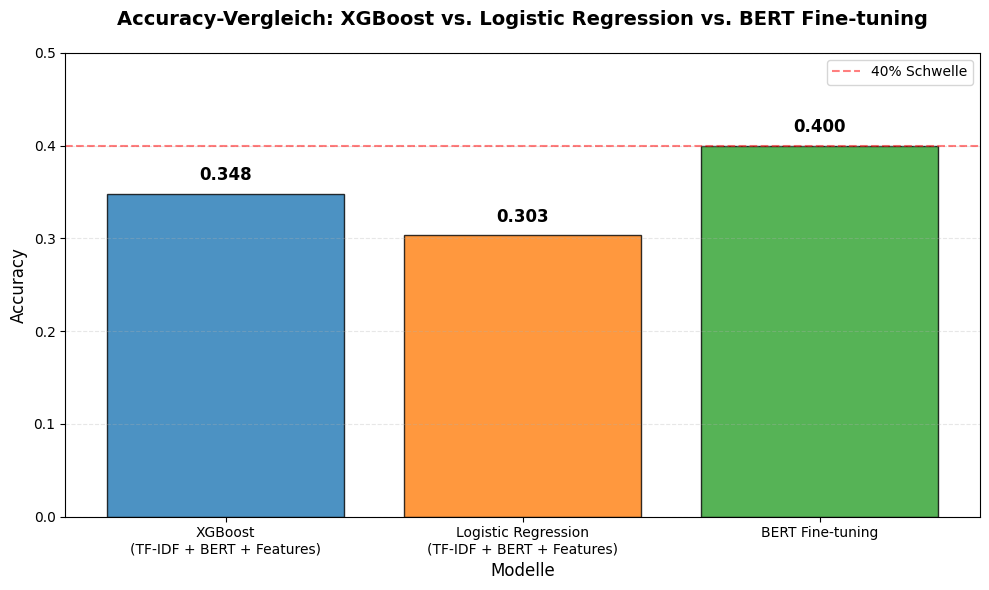

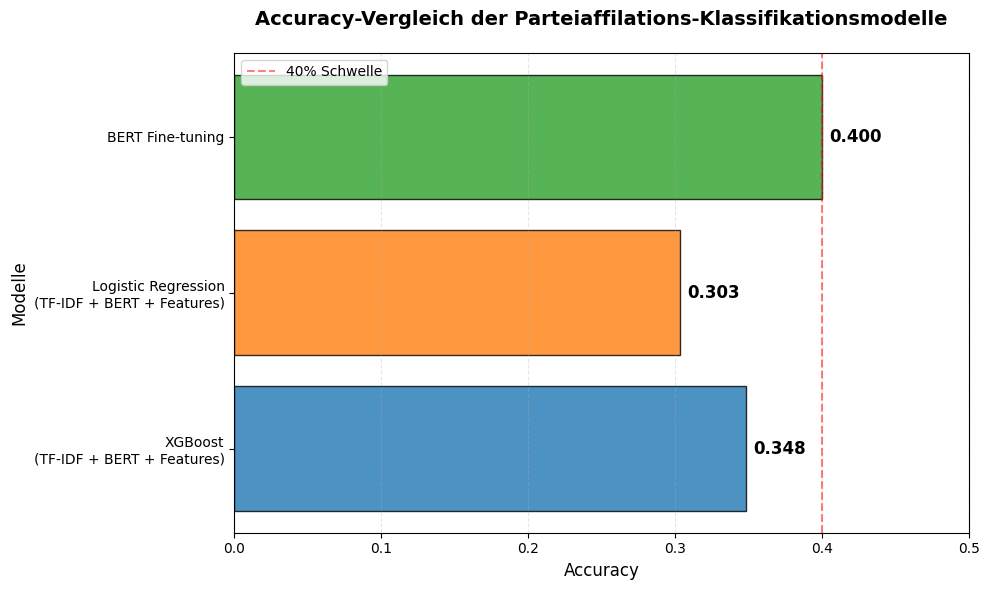

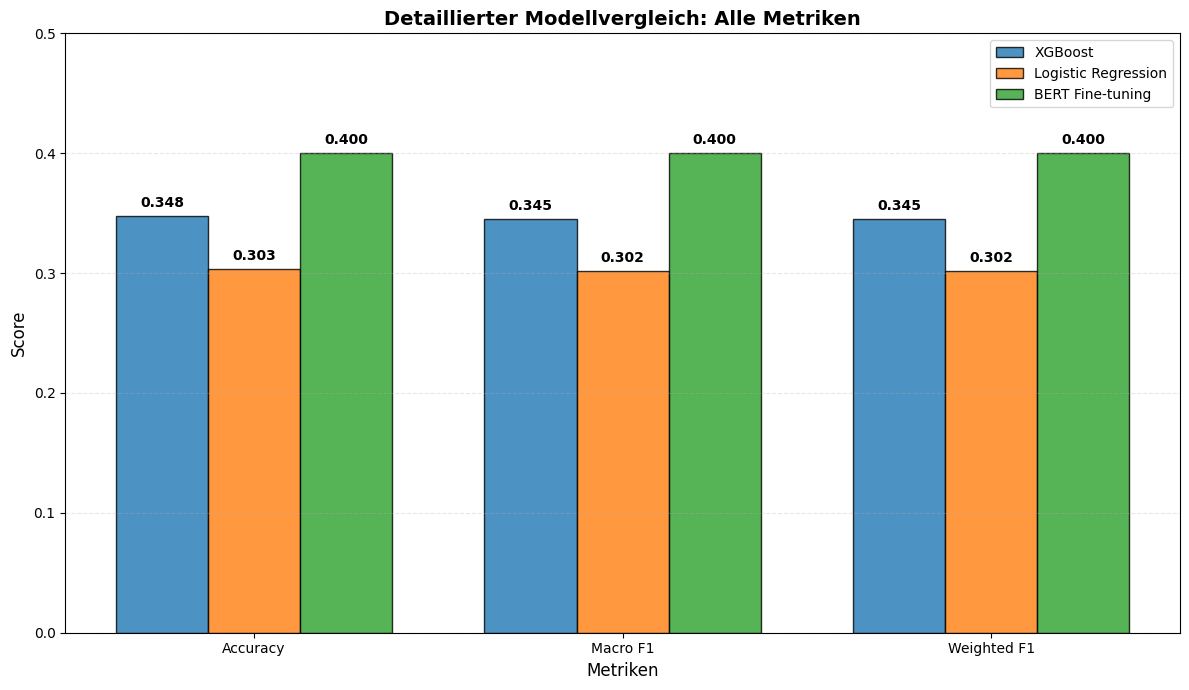

=== MODELL-PERFORMANCE ZUSAMMENFASSUNG ===
Modell                              Accuracy   Rang 
--------------------------------------------------
BERT Fine-tuning                    0.400      1    
XGBoost (TF-IDF + BERT + Features)  0.348      2    
Logistic Regression (TF-IDF + BERT + Features) 0.303      3    

Bestes Modell: BERT Fine-tuning mit 0.400 Accuracy


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Accuracy-Werte aus Ihrem Notebook extrahiert
model_names = ['XGBoost\n(TF-IDF + BERT + Features)', 'Logistic Regression\n(TF-IDF + BERT + Features)', 'BERT Fine-tuning']
accuracy_values = [0.348, 0.303, 0.40]  # Teil 13: XGBoost, Teil 11: LReg, Teil 14: BERT Fine-tuning

# Erstelle das Balkendiagramm
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'],
               alpha=0.8, edgecolor='black', linewidth=1)

# Füge Werte auf den Balken hinzu
for i, (bar, acc) in enumerate(zip(bars, accuracy_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Styling
plt.title('Accuracy-Vergleich: XGBoost vs. Logistic Regression vs. BERT Fine-tuning', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Modelle', fontsize=12)
plt.ylim(0, 0.5)  # Y-Achse von 0 bis 0.5
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Füge horizontale Linie für bessere Orientierung hinzu
plt.axhline(y=0.4, color='red', linestyle='--', alpha=0.5, label='40% Schwelle')

# Verbessere die Lesbarkeit der x-Achsen-Labels
plt.xticks(rotation=0, ha='center')
plt.tight_layout()

# Legende hinzufügen
plt.legend()

# Zeige das Diagramm
plt.show()

# Alternative: Horizontales Balkendiagramm für bessere Lesbarkeit
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(model_names))
bars = plt.barh(y_pos, accuracy_values, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'],
                alpha=0.8, edgecolor='black', linewidth=1)

# Füge Werte rechts neben den Balken hinzu
for i, acc in enumerate(accuracy_values):
    plt.text(acc + 0.005, i, f'{acc:.3f}', va='center', ha='left', 
             fontweight='bold', fontsize=12)

# Styling
plt.title('Accuracy-Vergleich der Parteiaffilations-Klassifikationsmodelle', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Modelle', fontsize=12)
plt.yticks(y_pos, model_names)
plt.xlim(0, 0.5)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Füge vertikale Linie für bessere Orientierung hinzu
plt.axvline(x=0.4, color='red', linestyle='--', alpha=0.5, label='40% Schwelle')

plt.tight_layout()
plt.legend()
plt.show()

# Dritte Option: Detaillierterer Vergleich mit zusätzlichen Metriken
# (Falls Sie auch F1-Scores vergleichen möchten)
metrics = ['Accuracy', 'Macro F1', 'Weighted F1']
xgboost_scores = [0.348, 0.345, 0.345]  # Teil 13: XGBoost (TF-IDF + BERT + Features)
logreg_scores = [0.303, 0.302, 0.302]   # Teil 11: Logistic Regression (TF-IDF + BERT + Features)
bert_scores = [0.40, 0.40, 0.40]        # Teil 14: BERT Fine-tuning

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width, xgboost_scores, width, label='XGBoost', 
               color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, logreg_scores, width, label='Logistic Regression', 
               color='#ff7f0e', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, bert_scores, width, label='BERT Fine-tuning', 
               color='#2ca02c', alpha=0.8, edgecolor='black')

# Füge Werte auf den Balken hinzu
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

ax.set_xlabel('Metriken', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Detaillierter Modellvergleich: Alle Metriken', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

# Zusammenfassung der Ergebnisse
print("=== MODELL-PERFORMANCE ZUSAMMENFASSUNG ===")
print(f"{'Modell':<35} {'Accuracy':<10} {'Rang':<5}")
print("-" * 50)

# Sortiere nach Accuracy für Ranking
results = list(zip(model_names, accuracy_values))
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

for i, (model, acc) in enumerate(results_sorted, 1):
    print(f"{model.replace(chr(10), ' '):<35} {acc:<10.3f} {i:<5}")

print(f"\nBestes Modell: {results_sorted[0][0].replace(chr(10), ' ')} mit {results_sorted[0][1]:.3f} Accuracy")